## Overview
* Country: United States, France, Germany, Japan, United Kingdom, Italy, Canada
* Time period: 1950-2018, 69 years
* Target variable: `ngdp_rpch` for annual data, `ngdp_r_sa_pcha` and `ngdp_r_sa_pchy` (respectively) for quarterly data
* Train-test split: 1950-2009 (train, ≤ x  years, depends on data availability), x - y (test, z years)   
  _Need further discussion. Here I divide the dataset by x/y just as the working paper did. Now for the ML model family we do not need to do such split._
  
* LSTM Model
* CNN Model

## Import packages

In [1]:
# Module 1: Importing the libraries

import tensorflow as tf
from tensorflow import keras
keras = tf.keras

# Print all outputs in a code block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Importing the libraries
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


# from tf.random import set_seed

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from keras.callbacks import ModelCheckpoint

# from keras.callbacks import ResetStatesCallback()

from keras.layers import Conv1D
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten,Dense
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
from tensorflow import random
# from tensorflow.random import set_seed

In [4]:
# Set Seed

seed_global = 42

# Source: https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

from numpy.random import seed
seed(seed_global)

#  Giving an eror 
# from tensorflow import set_random_seed
# set_random_seed(seed_global)

# Source: https://stackoverflow.com/questions/58638701/importerror-cannot-import-name-set-random-seed-from-tensorflow-c-users-po

tf.random.set_seed(seed_global)

# Copy paste this code snippet in every model code chunk 
seed(seed_global)
tf.random.set_seed(seed_global)

# --Ignore--
# tf.random.set_seed(seed)
# # This is giving me an error

# #  Global Seed
# # random.seed (2019) 

## Get data

In [5]:
%%bigquery gdp_quarterly_q

SELECT *
FROM `deep-nexus.temp_for_imf_data.WEO_G7_Quarterly`
ORDER BY time

In [6]:
gdp_quarterly_q.year = (gdp_quarterly_q.time+40)//4 + 1950
gdp_quarterly_q.quarter = (gdp_quarterly_q.time+40)%4 + 1
gdp_quarterly_q.time = gdp_quarterly_q.year.astype('str') + 'Q' + gdp_quarterly_q.quarter.astype('str')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [7]:
gdp_quarterly_q = pd.DataFrame(gdp_quarterly_q)
gdp_quarterly_q.head(5)

,country,ifscode,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,...,pcpi_sa,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt
0,United States,111,1950Q1,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
1,United Kingdom,112,1950Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,72.776393,NaN,72.776393,NaN,NaN,NaN,NaN
2,France,132,1950Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,47.016824,NaN,47.016824,NaN,NaN,NaN,NaN
3,Germany,134,1950Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Italy,136,1950Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Selecting a subset of countries
gdp_quarterly_q.country.unique()

selected_countries = list(gdp_quarterly_q.country.unique())[0:1]
print("\nSelected Countries: \n")
selected_countries

array(['United States', 'United Kingdom', 'France', 'Germany', 'Italy',
       'Canada', 'Japan'], dtype=object)


Selected Countries: 



['United States']

In [9]:
# dataset_2 = gdp_quarterly_q

# for i in selected_countries:
#    dataset_2[i] = gdp_quarterly_q[gdp_quarterly_q['country'] == i]

# https://stackoverflow.com/questions/51583888/concatenate-dataframe-name-with-variable-value-python

In [10]:
# # Random Forest Regressor

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

# # random forest model creation

# # Set Seed
# seed(seed_global)
# tensorflow.random.set_seed(seed_global)


# rfr = RandomForestRegressor(n_estimators = 1000)

# rfr.fit(X_train, y_train)

# # predictions
# y_pred = rfr.predict(X_test)

# metrics_mse["random_forest"] =  mean_squared_error(y_test, y_pred)

# print("Random Forest Test MSE: ", mean_squared_error(y_test, y_pred))

In [11]:
# # Variable Importance

# # Top i factors by importance

# i = 20
# importances = rf_reg.feature_importances_
# indices = np.argsort(importances)[-(i-1):]
# features = X.columns

# plt.figure(figsize=(6,6))
# plt.title('Feature Importances - Random Forest Regressor')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), features[indices])
# plt.xlabel('Relative Importance')

In [12]:
# Filter data by country

dataset = gdp_quarterly_q[gdp_quarterly_q['country'].isin(selected_countries)]

dataset = pd.DataFrame(dataset)
# print ("#", "column name", "missing values")
# for i in range(len(dataset.columns)):
#     print(i, dataset.columns[i], " ", dataset.iloc[i].isnull().count())

dataset.head(5)

,country,ifscode,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,...,pcpi_sa,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt
0,United States,111,1950Q1,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
7,United States,111,1950Q2,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
14,United States,111,1950Q3,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
21,United States,111,1950Q4,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
28,United States,111,1951Q1,NaN,NaN,NaN,0.062002,NaN,NaN,NaN,...,NaN,NaN,NaN,348.993057,NaN,348.993057,8.709073,11.508033,10.159067,12.875869


## Process data

In [13]:
dataset_input = dataset
dataset_input = dataset_input.drop(columns = ['country', 'ifscode', 'time', 'ngdp_r_sa_pcha', 'ngdp_r_sa_pchy', 'ngdp_dpchy'])
dataset_input.tail(5)

,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt
1897,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,12729.7,1.139334,...,247.273333,3.141889,2.109865,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625
1904,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,12782.9,0.417920,...,249.250333,3.236639,2.222997,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725
1911,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,12909.2,0.988039,...,250.578667,2.148827,2.668825,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725
1918,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,13019.8,0.856753,...,251.828667,2.010362,2.632912,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725
1925,18819.741667,11057.4,156.776667,0.162071,111.370,3.800000,2605.7,-0.011512,13066.3,0.357148,...,252.759000,1.485933,2.218463,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725


In [14]:
# Outcome vaiable (Column Name) = ngdp_r_sa_pcha

outcome_variable = "ngdp_r_sa_pcha"
predicted_variable = "1_step_ahead_" + outcome_variable

dataset_1 = dataset_input
dataset_1["time"] = dataset["time"]
# dataset_1[num_cols] = dataset[num_cols]
dataset_1[outcome_variable] = dataset[outcome_variable]

dataset_1[predicted_variable] = dataset_1[outcome_variable].shift(-1)

# # Source: https://stackoverflow.com/questions/20095673/shift-column-in-pandas-dataframe-up-by-one

dataset_1 = dataset_1[:-1] 

dataset_1.tail(5)

,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,time,ngdp_r_sa_pcha,1_step_ahead_ngdp_r_sa_pcha
1890,18155.700000,10456.7,153.815333,0.160311,110.185,4.300000,2553.6,0.145104,12586.3,0.586595,...,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,2017Q3,3.202964,3.545494
1897,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,12729.7,1.139334,...,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,2017Q4,3.545494,2.552107
1904,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,12782.9,0.417920,...,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2018Q1,2.552107,3.512025
1911,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,12909.2,0.988039,...,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2018Q2,3.512025,2.926498
1918,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,13019.8,0.856753,...,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2018Q3,2.926498,1.089155


In [15]:
# Output Columns

# ngdp_r_sa_pcha: WEO: Gross domestic product, constant prices, seasonally adjusted, quarter-over-quarter percent change, annualized (Percent, Units).

dataset_Y = dataset_1[["time", predicted_variable]]
dataset_Y.tail(5)

,time,1_step_ahead_ngdp_r_sa_pcha
1890,2017Q3,3.545494
1897,2017Q4,2.552107
1904,2018Q1,3.512025
1911,2018Q2,2.926498
1918,2018Q3,1.089155


In [16]:
# Window size and crearting the lagged columns

#  Using a lag = 0 for identifying initial variable importance by fitting a randowm forest 
# window size 
lag = 10
dataset_input_l = dataset_1

# Drop the 1) preducted outcome variable and 2) time variable 

dataset_input_l = dataset_input_l.drop(columns = ["time", predicted_variable])

print("Before adding the lagged variables to the input dataset: ")
dataset_input_l.tail(5)

# Lagging each column in num_columns by the entire range of lag factors

for j in dataset_input_l.columns:
    for i in range(1, (lag + 1), 1):
        new_col = str(j)+"-"+str(i)
        dataset_input_l[str(new_col)] = dataset_input_l[str(j)].shift(i)
    
print("After adding the lagged variables to the input dataset: ")
dataset_input_l.tail(5)

Before adding the lagged variables to the input dataset: 


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,ngdp_r_sa_pcha
1890,18155.700000,10456.7,153.815333,0.160311,110.185,4.300000,2553.6,0.145104,12586.3,0.586595,...,2.153214,1.981427,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,3.202964
1897,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,12729.7,1.139334,...,3.141889,2.109865,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,3.545494
1904,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,12782.9,0.417920,...,3.236639,2.222997,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2.552107
1911,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,12909.2,0.988039,...,2.148827,2.668825,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,3.512025
1918,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,13019.8,0.856753,...,2.010362,2.632912,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2.926498


After adding the lagged variables to the input dataset: 


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
1890,18155.700000,10456.7,153.815333,0.160311,110.185,4.300000,2553.6,0.145104,12586.3,0.586595,...,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962,0.130624,1.327969,2.998835,3.177823
1897,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,12729.7,1.139334,...,3.202964,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962,0.130624,1.327969,2.998835
1904,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,12782.9,0.417920,...,3.545494,3.202964,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962,0.130624,1.327969
1911,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,12909.2,0.988039,...,2.552107,3.545494,3.202964,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962,0.130624
1918,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,13019.8,0.856753,...,3.512025,2.552107,3.545494,3.202964,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962


In [17]:
# Combining Input and Output Values

# X1 = dataset_input
# X = pd.concat([X1, X2, dataset_Y], axis=1)
X = pd.concat([dataset_Y, dataset_input_l], axis=1)
X.head(5)
X.shape

print("\nColumns names:\n")
X.columns

,time,1_step_ahead_ngdp_r_sa_pcha,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
0,1950Q1,NaN,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1950Q2,NaN,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,1950Q3,NaN,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,1950Q4,NaN,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,1951Q1,NaN,NaN,NaN,NaN,0.062002,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(275, 673)


Columns names:



Index(['time', '1_step_ahead_ngdp_r_sa_pcha', 'gdpwgt', 'lc', 'le', 'llf',
       'lulcm', 'lur', 'ncg_r', 'ncg_rpch',
       ...
       'ngdp_r_sa_pcha-1', 'ngdp_r_sa_pcha-2', 'ngdp_r_sa_pcha-3',
       'ngdp_r_sa_pcha-4', 'ngdp_r_sa_pcha-5', 'ngdp_r_sa_pcha-6',
       'ngdp_r_sa_pcha-7', 'ngdp_r_sa_pcha-8', 'ngdp_r_sa_pcha-9',
       'ngdp_r_sa_pcha-10'],
      dtype='object', length=673)

In [18]:
# Dropping all rows with missing data
print("\nAfter dropping rows with missing data")
# X = X.iloc[lag:]
# X = X.iloc[:-1]
X = X.dropna()
X.shape
X.head(5)
X.tail(5)


After dropping rows with missing data


(145, 673)

,time,1_step_ahead_ngdp_r_sa_pcha,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
910,1982Q3,0.158923,2897.225,1904.8,99.543333,0.110231,92.663,9.900000,1515.5,1.026598,...,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985,-7.985864,1.261758
917,1982Q4,5.373663,2897.225,1918.1,99.119667,0.110231,93.691,10.666667,1532.7,1.134939,...,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985,-7.985864
924,1983Q1,9.421777,3136.050,1947.2,99.143000,0.111528,92.971,10.366667,1549.5,1.096105,...,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985
931,1983Q2,8.238399,3136.050,1986.3,99.945000,0.111528,92.457,10.133333,1561.6,0.780897,...,5.373663,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385
938,1983Q3,8.609839,3136.050,2029.6,101.610667,0.111528,91.532,9.366667,1580.2,1.191086,...,9.421777,5.373663,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747


,time,1_step_ahead_ngdp_r_sa_pcha,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
1890,2017Q3,3.545494,18155.700000,10456.7,153.815333,0.160311,110.185,4.300000,2553.6,0.145104,...,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962,0.130624,1.327969,2.998835,3.177823
1897,2017Q4,2.552107,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,...,3.202964,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962,0.130624,1.327969,2.998835
1904,2018Q1,3.512025,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,...,3.545494,3.202964,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962,0.130624,1.327969
1911,2018Q2,2.926498,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,...,2.552107,3.545494,3.202964,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962,0.130624
1918,2018Q3,1.089155,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,...,3.512025,2.552107,3.545494,3.202964,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962


In [19]:
# Separating input and output variables

X1 = X

Y1 = X1[predicted_variable]

Y1 = pd.DataFrame(Y1) # very important step, gave me formatting errors, and wasted 2 hour in debugging   

print("\n Outcome variable dimension", Y1.shape)
Y1.shape
Y1.head(5)

# Dropping outcome variable from input matrix
X1 = X1.drop(columns = [predicted_variable])
print("\n Input matrix: X")
X1.shape
X1.head(5)

print("\n columns in input dataset\n:")
X1.columns


 Outcome variable dimension (145, 1)


(145, 1)

,1_step_ahead_ngdp_r_sa_pcha
910,0.158923
917,5.373663
924,9.421777
931,8.238399
938,8.609839



 Input matrix: X


(145, 672)

,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
910,1982Q3,2897.225,1904.8,99.543333,0.110231,92.663,9.900000,1515.5,1.026598,4363.3,...,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985,-7.985864,1.261758
917,1982Q4,2897.225,1918.1,99.119667,0.110231,93.691,10.666667,1532.7,1.134939,4439.7,...,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985,-7.985864
924,1983Q1,3136.050,1947.2,99.143000,0.111528,92.971,10.366667,1549.5,1.096105,4483.6,...,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985
931,1983Q2,3136.050,1986.3,99.945000,0.111528,92.457,10.133333,1561.6,0.780897,4574.9,...,5.373663,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385
938,1983Q3,3136.050,2029.6,101.610667,0.111528,91.532,9.366667,1580.2,1.191086,4657.0,...,9.421777,5.373663,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747



 columns in input dataset
:


Index(['time', 'gdpwgt', 'lc', 'le', 'llf', 'lulcm', 'lur', 'ncg_r',
       'ncg_rpch', 'ncp_r',
       ...
       'ngdp_r_sa_pcha-1', 'ngdp_r_sa_pcha-2', 'ngdp_r_sa_pcha-3',
       'ngdp_r_sa_pcha-4', 'ngdp_r_sa_pcha-5', 'ngdp_r_sa_pcha-6',
       'ngdp_r_sa_pcha-7', 'ngdp_r_sa_pcha-8', 'ngdp_r_sa_pcha-9',
       'ngdp_r_sa_pcha-10'],
      dtype='object', length=672)

In [20]:
# Random Forest

# Sequential train-test split
train_test_ratio = 0.67

training = int(round(X1.shape[0]*train_test_ratio, 0))
test = X1.shape[0] - training

print("# items in training set:", training)
print("\n# items in test set:", test)

X_train = X1.iloc[0:(training),:]
y_train = Y1.iloc[0:(training),0]
X_test = X1.iloc[training:(X1.shape[0]),:]
y_test = Y1.iloc[training:(X1.shape[0]),0]
y_test_outcome_value = Y1.iloc[training:(X1.shape[0]),:]

print("\n input training set:")
X_train.shape
X_train.head(5)

y_train.head(5)

print("\n input test set:")
X_test.shape
X_test.head(5)

y_test.head(5)
y_test_outcome_value.head(5)

# items in training set: 97

# items in test set: 48

 input training set:


(97, 672)

,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
910,1982Q3,2897.225,1904.8,99.543333,0.110231,92.663,9.900000,1515.5,1.026598,4363.3,...,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985,-7.985864,1.261758
917,1982Q4,2897.225,1918.1,99.119667,0.110231,93.691,10.666667,1532.7,1.134939,4439.7,...,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985,-7.985864
924,1983Q1,3136.050,1947.2,99.143000,0.111528,92.971,10.366667,1549.5,1.096105,4483.6,...,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985
931,1983Q2,3136.050,1986.3,99.945000,0.111528,92.457,10.133333,1561.6,0.780897,4574.9,...,5.373663,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385
938,1983Q3,3136.050,2029.6,101.610667,0.111528,91.532,9.366667,1580.2,1.191086,4657.0,...,9.421777,5.373663,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747


910    0.158923
917    5.373663
924    9.421777
931    8.238399
938    8.609839
Name: 1_step_ahead_ngdp_r_sa_pcha, dtype: float64


 input test set:


(48, 672)

,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
1589,2006Q4,12236.20,7624.0,145.606000,0.151394,96.534,4.433333,2443.5,0.846059,10504.5,...,0.620939,0.938637,5.427471,2.548700,3.614058,1.859616,4.501177,4.067524,3.836396,3.084029
1596,2007Q1,13021.65,7806.8,146.135000,0.153119,96.994,4.500000,2444.9,0.057295,10563.3,...,3.449636,0.620939,0.938637,5.427471,2.548700,3.614058,1.859616,4.501177,4.067524,3.836396
1603,2007Q2,13021.65,7845.4,145.850667,0.153119,95.793,4.500000,2460.5,0.638063,10582.8,...,0.945307,3.449636,0.620939,0.938637,5.427471,2.548700,3.614058,1.859616,4.501177,4.067524
1610,2007Q3,13021.65,7885.1,145.943667,0.153119,95.084,4.666667,2472.8,0.499898,10642.5,...,2.312389,0.945307,3.449636,0.620939,0.938637,5.427471,2.548700,3.614058,1.859616,4.501177
1617,2007Q4,13021.65,7978.2,146.271333,0.153119,94.925,4.800000,2489.1,0.659172,10672.8,...,2.189473,2.312389,0.945307,3.449636,0.620939,0.938637,5.427471,2.548700,3.614058,1.859616


1589    0.945307
1596    2.312389
1603    2.189473
1610    2.455478
1617   -2.279453
Name: 1_step_ahead_ngdp_r_sa_pcha, dtype: float64

,1_step_ahead_ngdp_r_sa_pcha
1589,0.945307
1596,2.312389
1603,2.189473
1610,2.455478
1617,-2.279453


In [21]:
# Scaling the training & test sets 

# Dropping the "time" column

X_train.drop(columns = ['time'], inplace = True)
X_test.drop(columns = ['time'], inplace = True)

train_columns = list(X_train.columns)
# train_columns

# X_test  = X_test.drop(columns = ["time"], inplace = True)

X_train.head(5)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
910,2897.225,1904.8,99.543333,0.110231,92.663,9.900000,1515.5,1.026598,4363.3,0.669082,...,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985,-7.985864,1.261758
917,2897.225,1918.1,99.119667,0.110231,93.691,10.666667,1532.7,1.134939,4439.7,1.750968,...,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985,-7.985864
924,3136.050,1947.2,99.143000,0.111528,92.971,10.366667,1549.5,1.096105,4483.6,0.988806,...,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985
931,3136.050,1986.3,99.945000,0.111528,92.457,10.133333,1561.6,0.780897,4574.9,2.036310,...,5.373663,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385
938,3136.050,2029.6,101.610667,0.111528,91.532,9.366667,1580.2,1.191086,4657.0,1.794575,...,9.421777,5.373663,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747


In [22]:
# Scaling all the numerical variables
scaler = MinMaxScaler()

# train_columns = list(X_train.columns) # removing 'time' column for feature scaling
# train_columns


print("\nScaled training input dataset:")
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = train_columns)

X_train.head(5)

print("\nScaled test input dataset:")
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns = train_columns)

X_test.head(5)


Scaled training input dataset:


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
0,0.000000,0.000000,0.009326,0.000000,0.091959,0.886700,0.000000,0.761216,0.000000,0.511333,...,0.417280,0.000000,0.115132,0.706313,0.202857,0.912787,0.886813,0.361005,0.000000,0.531239
1,0.000000,0.002382,0.000000,0.000000,0.168567,1.000000,0.018891,0.783991,0.012648,0.898015,...,0.159268,0.510407,0.000000,0.115132,0.706313,0.202857,0.912787,0.886813,0.431355,0.000000
2,0.025573,0.007595,0.000514,0.031524,0.114912,0.955665,0.037342,0.775827,0.019916,0.625607,...,0.288318,0.293629,0.510407,0.000000,0.115132,0.706313,0.202857,0.912787,0.899275,0.431355
3,0.025573,0.014599,0.018168,0.031524,0.076608,0.921182,0.050632,0.709567,0.035030,1.000000,...,0.688976,0.402055,0.293629,0.510407,0.000000,0.115132,0.706313,0.202857,0.922389,0.899275
4,0.025573,0.022356,0.054834,0.031524,0.007676,0.807882,0.071060,0.795793,0.048622,0.913600,...,1.000000,0.738682,0.402055,0.293629,0.510407,0.000000,0.115132,0.706313,0.290619,0.922389



Scaled test input dataset:


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
0,0.000000,0.000000,0.413340,0.000000,0.095128,0.103261,0.019358,0.782466,0.033506,0.885535,...,0.647165,0.670012,0.992820,0.785797,0.862411,0.736243,0.926207,0.895021,0.878400,0.824295
1,0.119305,0.054238,0.443550,0.161546,0.122325,0.114130,0.025968,0.525182,0.056100,0.695181,...,0.850587,0.647165,0.670012,0.992820,0.785797,0.862411,0.736243,0.926207,0.895021,0.878400
2,0.119305,0.065691,0.427312,0.161546,0.051318,0.114130,0.099622,0.714620,0.063593,0.520215,...,0.670491,0.850587,0.647165,0.670012,0.992820,0.785797,0.862411,0.736243,0.926207,0.895021
3,0.119305,0.077471,0.432623,0.161546,0.009400,0.141304,0.157696,0.669553,0.086532,0.697215,...,0.768803,0.670491,0.850587,0.647165,0.670012,0.992820,0.785797,0.862411,0.736243,0.926207
4,0.119305,0.105095,0.451335,0.161546,0.000000,0.163043,0.234655,0.721506,0.098175,0.566902,...,0.759964,0.768803,0.670491,0.850587,0.647165,0.670012,0.992820,0.785797,0.862411,0.736243


In [23]:
if 'time' in X_train.columns:
    print("Does not exist")
else:
    print("Does not exist")
    
X_train

# train_cols = X_train.columns

# train_cols

Does not exist


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
0,0.000000,0.000000,0.009326,0.000000,0.091959,0.886700,0.000000,0.761216,0.000000,0.511333,...,0.417280,0.000000,0.115132,0.706313,0.202857,0.912787,0.886813,0.361005,0.000000,0.531239
1,0.000000,0.002382,0.000000,0.000000,0.168567,1.000000,0.018891,0.783991,0.012648,0.898015,...,0.159268,0.510407,0.000000,0.115132,0.706313,0.202857,0.912787,0.886813,0.431355,0.000000
2,0.025573,0.007595,0.000514,0.031524,0.114912,0.955665,0.037342,0.775827,0.019916,0.625607,...,0.288318,0.293629,0.510407,0.000000,0.115132,0.706313,0.202857,0.912787,0.899275,0.431355
3,0.025573,0.014599,0.018168,0.031524,0.076608,0.921182,0.050632,0.709567,0.035030,1.000000,...,0.688976,0.402055,0.293629,0.510407,0.000000,0.115132,0.706313,0.202857,0.922389,0.899275
4,0.025573,0.022356,0.054834,0.031524,0.007676,0.807882,0.071060,0.795793,0.048622,0.913600,...,1.000000,0.738682,0.402055,0.293629,0.510407,0.000000,0.115132,0.706313,0.290619,0.922389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.925039,0.934741,0.950243,0.949109,0.316715,0.157635,0.974080,0.634163,0.957206,0.619015,...,0.418985,0.682360,0.654367,0.639447,0.590879,0.530720,0.693273,0.841731,0.658839,0.587434
93,0.925039,0.950451,0.957126,0.949109,0.271332,0.157635,0.974739,0.550664,0.962189,0.378235,...,0.553782,0.511839,0.682360,0.654367,0.639447,0.590879,0.530720,0.693273,0.859155,0.658839
94,1.000000,0.980833,0.975830,1.000000,0.410314,0.123153,1.000000,0.746615,0.980978,0.670866,...,0.471929,0.625094,0.511839,0.682360,0.654367,0.639447,0.590879,0.530720,0.727043,0.859155
95,1.000000,0.989413,0.989441,1.000000,0.379611,0.108374,0.992641,0.487360,0.989604,0.453178,...,0.693110,0.556322,0.625094,0.511839,0.682360,0.654367,0.639447,0.590879,0.582385,0.727043


## Variable selection by Random Forest

In [24]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# random forest model creation
rfr = RandomForestRegressor(n_estimators = 5000)
rfr.fit(X_train, y_train)

# predictions
y_pred = rfr.predict(X_test)

print("Random Forest Test MSE: ", mean_squared_error(y_test, y_pred))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Random Forest Test MSE:  8.794497102516218



 Top variables (> 80% variation):  147 
 Total variation explained:  0.800255015178612
Top features: 


Index(['nfb_r-6', 'pcpi_pch-2', 'ncg_rpch', 'nm_rpch-3', 'ngdp_r_sa_ar-4',
       'nmg_rpch-10', 'nfdd_rpch-10', 'nm_rpch-9', 'lur-7', 'ngdp_d_sa_pchy-5',
       ...
       'ncp_rpchy', 'pcpi_pchy', 'ngdp_rpchy-9', 'ncp_rpch-1', 'nm_rpch',
       'lur-5', 'nfdd_rpch', 'ncp_rpch', 'nfbrgdp', 'nfi_rpch'],
      dtype='object', length=147)

<Figure size 720x2160 with 0 Axes>

Text(0.5, 1.0, 'Feature Importances - Random Forest Regressor')

<BarContainer object of 147 artists>

([<matplotlib.axis.YTick at 0x7f0c94d845c0>,
 <a list of 147 Text yticklabel objects>)

Text(0.5, 0, 'Relative Importance')

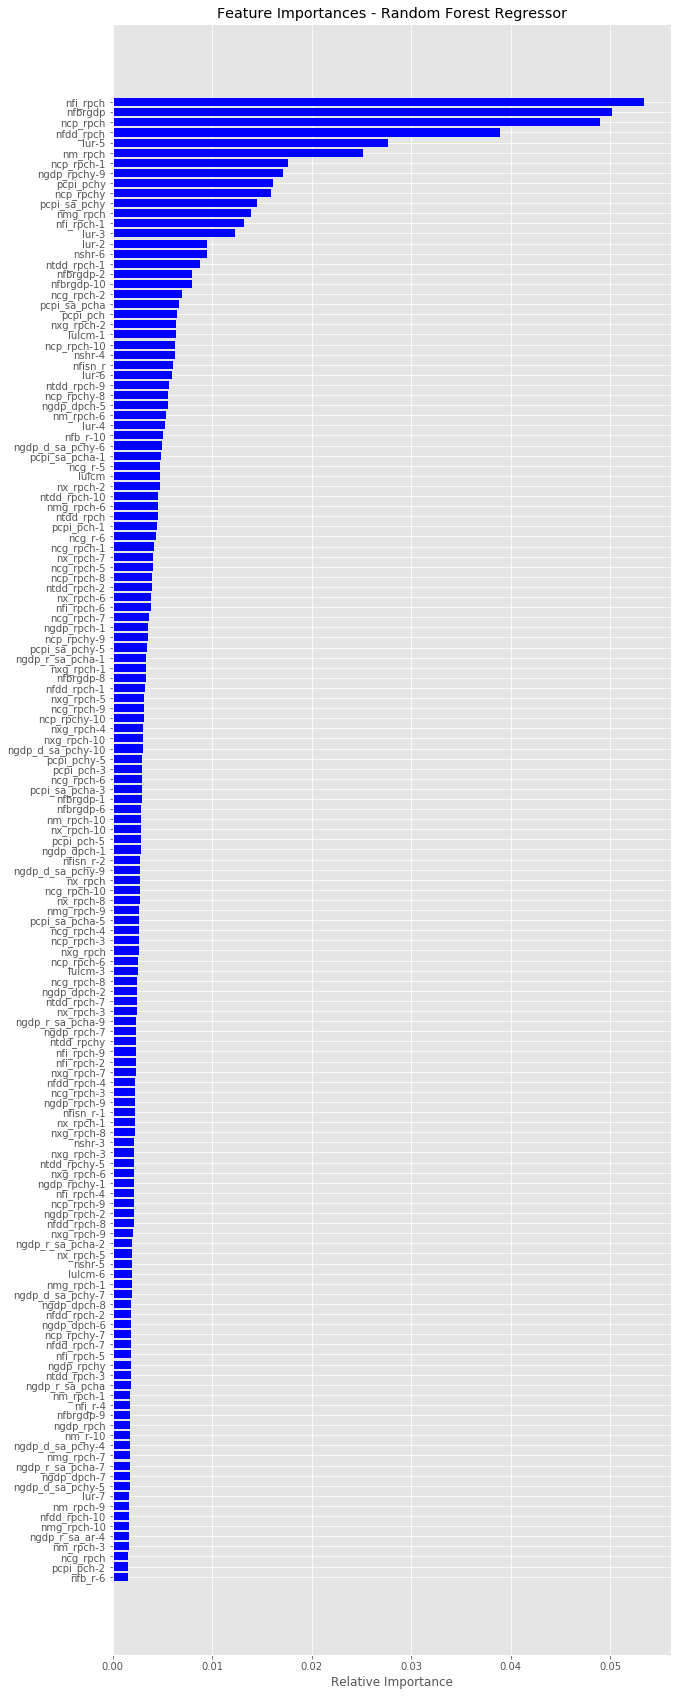

In [25]:
# Variable Importance
# i = 20

importances =  rfr.feature_importances_
top_features = []

imp_1 = sorted(np.array(importances), reverse = True)
sum = 0 
for i in range(len(imp_1)):
    sum = sum + imp_1[i]
    if sum > 0.8:
        n = i
        print("\n Top variables (> 80% variation): ", n+1, "\n Total variation explained: ", sum)
        break
                       
i = n

indices = np.argsort(importances)[-(i+1):]
 
print("Top features: ")

features = X_train.columns

top_features = features[indices]
top_features

plt.figure(figsize=(10,30))
plt.title('Feature Importances - Random Forest Regressor')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [26]:
#  Important features

print("\n Total important variables: ", len(top_features))
print("\n Important features: \n")
top_features


 Total important variables:  147

 Important features: 



Index(['nfb_r-6', 'pcpi_pch-2', 'ncg_rpch', 'nm_rpch-3', 'ngdp_r_sa_ar-4',
       'nmg_rpch-10', 'nfdd_rpch-10', 'nm_rpch-9', 'lur-7', 'ngdp_d_sa_pchy-5',
       ...
       'ncp_rpchy', 'pcpi_pchy', 'ngdp_rpchy-9', 'ncp_rpch-1', 'nm_rpch',
       'lur-5', 'nfdd_rpch', 'ncp_rpch', 'nfbrgdp', 'nfi_rpch'],
      dtype='object', length=147)

In [27]:
# Train & Test set with important features from random forest

X_train_random_forest = X_train[top_features]
X_train_random_forest.shape

X_test_random_forest = X_test[top_features]
X_test_random_forest.shape

(97, 147)

(48, 147)

## LSTM

In [28]:
# Reshaping the training and test sets
X_train_1 = np.array(X_train_random_forest).reshape(X_train_random_forest.shape[0], X_train_random_forest.shape[1],1)
print("training set reshaped:", X_train_1.shape)

X_test_1 = np.array(X_test_random_forest).reshape(X_test_random_forest.shape[0], X_test_random_forest.shape[1],1)
print("test set reshaped:", X_test_1.shape)

training set reshaped: (97, 147, 1)
test set reshaped: (48, 147, 1)


In [29]:
import wandb
from keras.layers import LSTM
from wandb.keras import WandbCallback

In [30]:
#wandb.init(project='IMF')

## 1. General tuning for all params

In [31]:
sweep_config_1 = {
    'method': 'grid',
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    'parameters': {
                  'epochs': {'values': [10, 20]},
                  'batch_size': {'values': [32, 64]},
                  'nn_units': {'values': [16, 32, 64]},
                  'dout_rate': {'values': [0.0, 0.2, 0.4, 0.6]},
    }
}

In [32]:
sweepid_1 = wandb.sweep(sweep_config_1)

Create sweep with ID: gdke1z5v
Sweep URL: https://app.wandb.ai/fiscal-forcast/IMF/sweeps/gdke1z5v


In [33]:
def train_1():
    
    # Specify the hyperparameter to be tuned along with
    # an initial value
    config_defaults = {
        'epochs': 10,
        'batch_size': 32,
        'nn_units': 16,
        'dout_rate': 0.0
    }
    
    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model
    model = Sequential()
    model.add(LSTM(units = config.nn_units, return_sequences = True, input_shape = (X_train_1.shape[1], 1)))
    model.add(Dropout(config.dout_rate))
    model.add(LSTM(units = config.nn_units, return_sequences = True))
    model.add(Dropout(config.dout_rate))
    model.add(LSTM(units = config.nn_units, return_sequences = True))
    model.add(Dropout(config.dout_rate))
    model.add(LSTM(units = config.nn_units, return_sequences = True))
    model.add(Dropout(config.dout_rate))
    model.add(LSTM(units = config.nn_units, return_sequences = True))
    model.add(Dropout(config.dout_rate))
    model.add(LSTM(units = config.nn_units, return_sequences = True))
    model.add(Dropout(config.dout_rate))
    model.add(LSTM(units = config.nn_units))
    model.add(Dense(units = 1, activation='relu'))
    
    # Complie the model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])
    
    # Train the model
    model.fit(X_train_1, y_train, epochs = config.epochs, batch_size = config.batch_size, 
              validation_split = 0.3, callbacks=[WandbCallback()])

In [34]:
wandb.agent(sweepid_1, function=train_1)

wandb: Agent Starting Run: y7bptumc with config:
	epochs: 10
	nn_units: 16
	batch_size: 32
	dout_rate: 0
wandb: Agent Started Run: y7bptumc


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 6s 95ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/10
67/67 [==============================] - 2s 24ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/10
67/67 [==============================] - 2s 23ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/10
67/67 [==============================] - 2s 23ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/10
67/67 [==============================] - 2s 27ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/10
67/67 [==============================] - 2s 27ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/10
67/67 [==============================] - 2s 26ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 69ms/step - loss: 18.9613 - mse: 18.9613 - val_loss: 12.3290 - val_mse: 12.3290
Epoch 2/10
67/67 [==============================] - 2s 24ms/step - loss: 17.5686 - mse: 17.5686 - val_loss: 10.0546 - val_mse: 10.0546
Epoch 3/10
67/67 [==============================] - 2s 25ms/step - loss: 14.0594 - mse: 14.0594 - val_loss: 7.0938 - val_mse: 7.0938
Epoch 4/10
67/67 [==============================] - 2s 24ms/step - loss: 10.0961 - mse: 10.0961 - val_loss: 5.2962 - val_mse: 5.2962
Epoch 5/10
67/67 [==============================] - 2s 24ms/step - loss: 7.3040 - mse: 7.3040 - val_loss: 4.7576 - val_mse: 4.7576
Epoch 6/10
67/67 [==============================] - 2s 24ms/step - loss: 5.7641 - mse: 5.7641 - val_loss: 5.1299 - val_mse: 5.1299
Epoch 7/10
67/67 [==============================] - 2s 23ms/step - loss: 5.2969 - mse: 5.2969 - val_loss: 5.8663 - val_mse: 5.8663
Epoch 8/10
67/67 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 72ms/step - loss: 18.6604 - mse: 18.6604 - val_loss: 10.0009 - val_mse: 10.0009
Epoch 2/10
67/67 [==============================] - 2s 28ms/step - loss: 12.6335 - mse: 12.6335 - val_loss: 5.0288 - val_mse: 5.0288
Epoch 3/10
67/67 [==============================] - 2s 27ms/step - loss: 6.4252 - mse: 6.4252 - val_loss: 5.4684 - val_mse: 5.4684
Epoch 4/10
67/67 [==============================] - 2s 27ms/step - loss: 5.2638 - mse: 5.2638 - val_loss: 7.2303 - val_mse: 7.2303
Epoch 5/10
67/67 [==============================] - 2s 27ms/step - loss: 5.7959 - mse: 5.7959 - val_loss: 7.4012 - val_mse: 7.4012
Epoch 6/10
67/67 [==============================] - 2s 28ms/step - loss: 5.8548 - mse: 5.8548 - val_loss: 7.0226 - val_mse: 7.0226
Epoch 7/10
67/67 [==============================] - 2s 30ms/step - loss: 5.6493 - mse: 5.6493 - val_loss: 6.3706 - val_mse: 6.3706
Epoch 8/10
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 68ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/20
67/67 [==============================] - 2s 24ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/20
67/67 [==============================] - 2s 24ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/20
67/67 [==============================] - 2s 23ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/20
67/67 [==============================] - 2s 23ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/20
67/67 [==============================] - 2s 23ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/20
67/67 [==============================] - 2s 23ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/20


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 69ms/step - loss: 18.9613 - mse: 18.9613 - val_loss: 12.3290 - val_mse: 12.3290
Epoch 2/20
67/67 [==============================] - 2s 24ms/step - loss: 17.5686 - mse: 17.5686 - val_loss: 10.0546 - val_mse: 10.0546
Epoch 3/20
67/67 [==============================] - 2s 24ms/step - loss: 14.0594 - mse: 14.0594 - val_loss: 7.0938 - val_mse: 7.0938
Epoch 4/20
67/67 [==============================] - 2s 24ms/step - loss: 10.0961 - mse: 10.0961 - val_loss: 5.2962 - val_mse: 5.2962
Epoch 5/20
67/67 [==============================] - 2s 24ms/step - loss: 7.3040 - mse: 7.3040 - val_loss: 4.7576 - val_mse: 4.7576
Epoch 6/20
67/67 [==============================] - 2s 24ms/step - loss: 5.7641 - mse: 5.7641 - val_loss: 5.1299 - val_mse: 5.1299
Epoch 7/20
67/67 [==============================] - 2s 24ms/step - loss: 5.2969 - mse: 5.2969 - val_loss: 5.8663 - val_mse: 5.8663
Epoch 8/20
67/67 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 72ms/step - loss: 18.6604 - mse: 18.6604 - val_loss: 10.0009 - val_mse: 10.0009
Epoch 2/20
67/67 [==============================] - 2s 28ms/step - loss: 12.6335 - mse: 12.6335 - val_loss: 5.0127 - val_mse: 5.0127
Epoch 3/20
67/67 [==============================] - 2s 27ms/step - loss: 6.3951 - mse: 6.3951 - val_loss: 5.4844 - val_mse: 5.4844
Epoch 4/20
67/67 [==============================] - 2s 27ms/step - loss: 5.2670 - mse: 5.2670 - val_loss: 7.2416 - val_mse: 7.2416
Epoch 5/20
67/67 [==============================] - 2s 28ms/step - loss: 5.8010 - mse: 5.8010 - val_loss: 7.4004 - val_mse: 7.4004
Epoch 6/20
67/67 [==============================] - 2s 27ms/step - loss: 5.8536 - mse: 5.8536 - val_loss: 7.0136 - val_mse: 7.0136
Epoch 7/20
67/67 [==============================] - 2s 27ms/step - loss: 5.6455 - mse: 5.6455 - val_loss: 6.3636 - val_mse: 6.3636
Epoch 8/20
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 73ms/step - loss: 18.9682 - mse: 18.9682 - val_loss: 12.7508 - val_mse: 12.7508
Epoch 2/10
67/67 [==============================] - 2s 24ms/step - loss: 18.4814 - mse: 18.4814 - val_loss: 12.1259 - val_mse: 12.1259
Epoch 3/10
67/67 [==============================] - 2s 24ms/step - loss: 17.6001 - mse: 17.6001 - val_loss: 11.0433 - val_mse: 11.0433
Epoch 4/10
67/67 [==============================] - 2s 24ms/step - loss: 16.0371 - mse: 16.0371 - val_loss: 9.6485 - val_mse: 9.6485
Epoch 5/10
67/67 [==============================] - 2s 23ms/step - loss: 14.2162 - mse: 14.2162 - val_loss: 8.4053 - val_mse: 8.4053
Epoch 6/10
67/67 [==============================] - 2s 23ms/step - loss: 12.5761 - mse: 12.5761 - val_loss: 7.4666 - val_mse: 7.4666
Epoch 7/10
67/67 [==============================] - 2s 23ms/step - loss: 11.2926 - mse: 11.2926 - val_loss: 6.7711 - val_mse: 6.7711
Epoch 8/10
67/67 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 73ms/step - loss: 18.9997 - mse: 18.9997 - val_loss: 12.4234 - val_mse: 12.4234
Epoch 2/10
67/67 [==============================] - 2s 26ms/step - loss: 17.8105 - mse: 17.8105 - val_loss: 10.3983 - val_mse: 10.3983
Epoch 3/10
67/67 [==============================] - 2s 25ms/step - loss: 14.5141 - mse: 14.5141 - val_loss: 7.0726 - val_mse: 7.0726
Epoch 4/10
67/67 [==============================] - 2s 25ms/step - loss: 10.1364 - mse: 10.1364 - val_loss: 5.4576 - val_mse: 5.4576
Epoch 5/10
67/67 [==============================] - 2s 25ms/step - loss: 7.7814 - mse: 7.7814 - val_loss: 4.8361 - val_mse: 4.8361
Epoch 6/10
67/67 [==============================] - 2s 25ms/step - loss: 6.3636 - mse: 6.3636 - val_loss: 4.8026 - val_mse: 4.8026
Epoch 7/10
67/67 [==============================] - 2s 25ms/step - loss: 5.6089 - mse: 5.6089 - val_loss: 5.1644 - val_mse: 5.1644
Epoch 8/10
67/67 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 75ms/step - loss: 18.7814 - mse: 18.7814 - val_loss: 11.1260 - val_mse: 11.1260
Epoch 2/10
67/67 [==============================] - 2s 29ms/step - loss: 14.7050 - mse: 14.7050 - val_loss: 5.0113 - val_mse: 5.0113
Epoch 3/10
67/67 [==============================] - 2s 28ms/step - loss: 6.3707 - mse: 6.3707 - val_loss: 5.8502 - val_mse: 5.8502
Epoch 4/10
67/67 [==============================] - 2s 28ms/step - loss: 5.3283 - mse: 5.3283 - val_loss: 6.9785 - val_mse: 6.9785
Epoch 5/10
67/67 [==============================] - 2s 28ms/step - loss: 5.5920 - mse: 5.5920 - val_loss: 6.3604 - val_mse: 6.3604
Epoch 6/10
67/67 [==============================] - 2s 28ms/step - loss: 5.3768 - mse: 5.3768 - val_loss: 5.6627 - val_mse: 5.6627
Epoch 7/10
67/67 [==============================] - 2s 28ms/step - loss: 5.1801 - mse: 5.1801 - val_loss: 5.1692 - val_mse: 5.1692
Epoch 8/10
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 72ms/step - loss: 18.9447 - mse: 18.9447 - val_loss: 12.6715 - val_mse: 12.6715
Epoch 2/20
67/67 [==============================] - 2s 24ms/step - loss: 18.3566 - mse: 18.3566 - val_loss: 11.9439 - val_mse: 11.9439
Epoch 3/20
67/67 [==============================] - 2s 24ms/step - loss: 17.3400 - mse: 17.3400 - val_loss: 10.7551 - val_mse: 10.7551
Epoch 4/20
67/67 [==============================] - 2s 23ms/step - loss: 15.6552 - mse: 15.6552 - val_loss: 9.3665 - val_mse: 9.3665
Epoch 5/20
67/67 [==============================] - 2s 23ms/step - loss: 13.8562 - mse: 13.8562 - val_loss: 8.2045 - val_mse: 8.2045
Epoch 6/20
67/67 [==============================] - 2s 23ms/step - loss: 12.3066 - mse: 12.3066 - val_loss: 7.3277 - val_mse: 7.3277
Epoch 7/20
67/67 [==============================] - 2s 23ms/step - loss: 11.0899 - mse: 11.0899 - val_loss: 6.6784 - val_mse: 6.6784
Epoch 8/20
67/67 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 74ms/step - loss: 18.9585 - mse: 18.9585 - val_loss: 12.2150 - val_mse: 12.2150
Epoch 2/20
67/67 [==============================] - 2s 30ms/step - loss: 17.4383 - mse: 17.4383 - val_loss: 9.7377 - val_mse: 9.7377
Epoch 3/20
67/67 [==============================] - 2s 30ms/step - loss: 13.5889 - mse: 13.5889 - val_loss: 6.6078 - val_mse: 6.6078
Epoch 4/20
67/67 [==============================] - 2s 29ms/step - loss: 9.5368 - mse: 9.5368 - val_loss: 5.2824 - val_mse: 5.2824
Epoch 5/20
67/67 [==============================] - 2s 29ms/step - loss: 7.4487 - mse: 7.4487 - val_loss: 4.7925 - val_mse: 4.7925
Epoch 6/20
67/67 [==============================] - 2s 27ms/step - loss: 6.1841 - mse: 6.1841 - val_loss: 4.8401 - val_mse: 4.8401
Epoch 7/20
67/67 [==============================] - 2s 25ms/step - loss: 5.5317 - mse: 5.5317 - val_loss: 5.2378 - val_mse: 5.2378
Epoch 8/20
67/67 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 76ms/step - loss: 18.7814 - mse: 18.7814 - val_loss: 11.1260 - val_mse: 11.1260
Epoch 2/20
67/67 [==============================] - 2s 28ms/step - loss: 14.7050 - mse: 14.7050 - val_loss: 5.0113 - val_mse: 5.0113
Epoch 3/20
67/67 [==============================] - 2s 29ms/step - loss: 6.3707 - mse: 6.3707 - val_loss: 5.8502 - val_mse: 5.8502
Epoch 4/20
67/67 [==============================] - 2s 28ms/step - loss: 5.3283 - mse: 5.3283 - val_loss: 6.9785 - val_mse: 6.9785
Epoch 5/20
67/67 [==============================] - 2s 28ms/step - loss: 5.5920 - mse: 5.5920 - val_loss: 6.3604 - val_mse: 6.3604
Epoch 6/20
67/67 [==============================] - 2s 28ms/step - loss: 5.3768 - mse: 5.3768 - val_loss: 5.6627 - val_mse: 5.6627
Epoch 7/20
67/67 [==============================] - 2s 28ms/step - loss: 5.1801 - mse: 5.1801 - val_loss: 5.1692 - val_mse: 5.1692
Epoch 8/20
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 71ms/step - loss: 18.9728 - mse: 18.9728 - val_loss: 12.7599 - val_mse: 12.7599
Epoch 2/10
67/67 [==============================] - 2s 23ms/step - loss: 18.5218 - mse: 18.5218 - val_loss: 12.1696 - val_mse: 12.1696
Epoch 3/10
67/67 [==============================] - 2s 23ms/step - loss: 17.6851 - mse: 17.6851 - val_loss: 11.1535 - val_mse: 11.1535
Epoch 4/10
67/67 [==============================] - 2s 23ms/step - loss: 16.2080 - mse: 16.2080 - val_loss: 9.7876 - val_mse: 9.7876
Epoch 5/10
67/67 [==============================] - 2s 23ms/step - loss: 14.4569 - mse: 14.4569 - val_loss: 8.5210 - val_mse: 8.5210
Epoch 6/10
67/67 [==============================] - 2s 23ms/step - loss: 13.0247 - mse: 13.0247 - val_loss: 7.5657 - val_mse: 7.5657
Epoch 7/10
67/67 [==============================] - 2s 23ms/step - loss: 11.7605 - mse: 11.7605 - val_loss: 6.8599 - val_mse: 6.8599
Epoch 8/10
67/67 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 73ms/step - loss: 18.9995 - mse: 18.9995 - val_loss: 12.4199 - val_mse: 12.4199
Epoch 2/10
67/67 [==============================] - 2s 26ms/step - loss: 17.8061 - mse: 17.8061 - val_loss: 10.3965 - val_mse: 10.3965
Epoch 3/10
67/67 [==============================] - 2s 25ms/step - loss: 14.5761 - mse: 14.5761 - val_loss: 7.0791 - val_mse: 7.0791
Epoch 4/10
67/67 [==============================] - 2s 24ms/step - loss: 10.3469 - mse: 10.3469 - val_loss: 5.4770 - val_mse: 5.4770
Epoch 5/10
67/67 [==============================] - 2s 25ms/step - loss: 7.9833 - mse: 7.9833 - val_loss: 4.8493 - val_mse: 4.8493
Epoch 6/10
67/67 [==============================] - 2s 24ms/step - loss: 6.5761 - mse: 6.5761 - val_loss: 4.7906 - val_mse: 4.7906
Epoch 7/10
67/67 [==============================] - 2s 24ms/step - loss: 5.6532 - mse: 5.6532 - val_loss: 5.1265 - val_mse: 5.1265
Epoch 8/10
67/67 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 75ms/step - loss: 18.7929 - mse: 18.7929 - val_loss: 11.2071 - val_mse: 11.2071
Epoch 2/10
67/67 [==============================] - 2s 29ms/step - loss: 14.8567 - mse: 14.8567 - val_loss: 5.0530 - val_mse: 5.0530
Epoch 3/10
67/67 [==============================] - 2s 28ms/step - loss: 6.5882 - mse: 6.5882 - val_loss: 5.7942 - val_mse: 5.7942
Epoch 4/10
67/67 [==============================] - 2s 28ms/step - loss: 5.3246 - mse: 5.3246 - val_loss: 7.0491 - val_mse: 7.0491
Epoch 5/10
67/67 [==============================] - 2s 28ms/step - loss: 5.5414 - mse: 5.5414 - val_loss: 6.5257 - val_mse: 6.5257
Epoch 6/10
67/67 [==============================] - 2s 27ms/step - loss: 5.3488 - mse: 5.3488 - val_loss: 5.8273 - val_mse: 5.8273
Epoch 7/10
67/67 [==============================] - 2s 28ms/step - loss: 5.2047 - mse: 5.2047 - val_loss: 5.2826 - val_mse: 5.2826
Epoch 8/10
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 71ms/step - loss: 18.9728 - mse: 18.9728 - val_loss: 12.7599 - val_mse: 12.7599
Epoch 2/20
67/67 [==============================] - 2s 24ms/step - loss: 18.5218 - mse: 18.5218 - val_loss: 12.1696 - val_mse: 12.1696
Epoch 3/20
67/67 [==============================] - 2s 23ms/step - loss: 17.6851 - mse: 17.6851 - val_loss: 11.1535 - val_mse: 11.1535
Epoch 4/20
67/67 [==============================] - 2s 23ms/step - loss: 16.2080 - mse: 16.2080 - val_loss: 9.7876 - val_mse: 9.7876
Epoch 5/20
67/67 [==============================] - 2s 23ms/step - loss: 14.4569 - mse: 14.4569 - val_loss: 8.5210 - val_mse: 8.5210
Epoch 6/20
67/67 [==============================] - 2s 23ms/step - loss: 13.0247 - mse: 13.0247 - val_loss: 7.5657 - val_mse: 7.5657
Epoch 7/20
67/67 [==============================] - 2s 23ms/step - loss: 11.7605 - mse: 11.7605 - val_loss: 6.8599 - val_mse: 6.8599
Epoch 8/20
67/67 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 73ms/step - loss: 18.9995 - mse: 18.9995 - val_loss: 12.4199 - val_mse: 12.4199
Epoch 2/20
67/67 [==============================] - 2s 25ms/step - loss: 17.8061 - mse: 17.8061 - val_loss: 10.3965 - val_mse: 10.3965
Epoch 3/20
67/67 [==============================] - 2s 25ms/step - loss: 14.5604 - mse: 14.5604 - val_loss: 7.0632 - val_mse: 7.0632
Epoch 4/20
67/67 [==============================] - 2s 24ms/step - loss: 10.3250 - mse: 10.3250 - val_loss: 5.4706 - val_mse: 5.4706
Epoch 5/20
67/67 [==============================] - 2s 23ms/step - loss: 7.9713 - mse: 7.9713 - val_loss: 4.8475 - val_mse: 4.8475
Epoch 6/20
67/67 [==============================] - 2s 23ms/step - loss: 6.5689 - mse: 6.5689 - val_loss: 4.7921 - val_mse: 4.7921
Epoch 7/20
67/67 [==============================] - 2s 23ms/step - loss: 5.6481 - mse: 5.6481 - val_loss: 5.1304 - val_mse: 5.1304
Epoch 8/20
67/67 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 76ms/step - loss: 18.7929 - mse: 18.7929 - val_loss: 11.2071 - val_mse: 11.2071
Epoch 2/20
67/67 [==============================] - 2s 28ms/step - loss: 14.8567 - mse: 14.8567 - val_loss: 5.0530 - val_mse: 5.0530
Epoch 3/20
67/67 [==============================] - 2s 27ms/step - loss: 6.5882 - mse: 6.5882 - val_loss: 5.7942 - val_mse: 5.7942
Epoch 4/20
67/67 [==============================] - 2s 27ms/step - loss: 5.3246 - mse: 5.3246 - val_loss: 7.0491 - val_mse: 7.0491
Epoch 5/20
67/67 [==============================] - 2s 27ms/step - loss: 5.5414 - mse: 5.5414 - val_loss: 6.5257 - val_mse: 6.5257
Epoch 6/20
67/67 [==============================] - 2s 27ms/step - loss: 5.3488 - mse: 5.3488 - val_loss: 5.8273 - val_mse: 5.8273
Epoch 7/20
67/67 [==============================] - 2s 27ms/step - loss: 5.2047 - mse: 5.2047 - val_loss: 5.2826 - val_mse: 5.2826
Epoch 8/20
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 71ms/step - loss: 18.9595 - mse: 18.9595 - val_loss: 12.6813 - val_mse: 12.6813
Epoch 2/10
67/67 [==============================] - 2s 24ms/step - loss: 18.4257 - mse: 18.4257 - val_loss: 12.0072 - val_mse: 12.0072
Epoch 3/10
67/67 [==============================] - 2s 24ms/step - loss: 17.5254 - mse: 17.5254 - val_loss: 10.8855 - val_mse: 10.8855
Epoch 4/10
67/67 [==============================] - 2s 23ms/step - loss: 16.0792 - mse: 16.0792 - val_loss: 9.5131 - val_mse: 9.5131
Epoch 5/10
67/67 [==============================] - 2s 23ms/step - loss: 14.4617 - mse: 14.4617 - val_loss: 8.3602 - val_mse: 8.3602
Epoch 6/10
67/67 [==============================] - 2s 23ms/step - loss: 13.2906 - mse: 13.2906 - val_loss: 7.4981 - val_mse: 7.4981
Epoch 7/10
67/67 [==============================] - 2s 23ms/step - loss: 12.1235 - mse: 12.1235 - val_loss: 6.8542 - val_mse: 6.8542
Epoch 8/10
67/67 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 71ms/step - loss: 18.9458 - mse: 18.9458 - val_loss: 12.2330 - val_mse: 12.2330
Epoch 2/10
67/67 [==============================] - 2s 25ms/step - loss: 17.5447 - mse: 17.5447 - val_loss: 9.9347 - val_mse: 9.9347
Epoch 3/10
67/67 [==============================] - 2s 25ms/step - loss: 14.0950 - mse: 14.0950 - val_loss: 6.7692 - val_mse: 6.7692
Epoch 4/10
67/67 [==============================] - 2s 25ms/step - loss: 10.4201 - mse: 10.4201 - val_loss: 5.3779 - val_mse: 5.3779
Epoch 5/10
67/67 [==============================] - 2s 25ms/step - loss: 8.1865 - mse: 8.1865 - val_loss: 4.8288 - val_mse: 4.8288
Epoch 6/10
67/67 [==============================] - 2s 24ms/step - loss: 6.9167 - mse: 6.9167 - val_loss: 4.7963 - val_mse: 4.7963
Epoch 7/10
67/67 [==============================] - 2s 25ms/step - loss: 5.7617 - mse: 5.7617 - val_loss: 5.1171 - val_mse: 5.1171
Epoch 8/10
67/67 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 76ms/step - loss: 18.8579 - mse: 18.8579 - val_loss: 11.6642 - val_mse: 11.6642
Epoch 2/10
67/67 [==============================] - 2s 28ms/step - loss: 15.9088 - mse: 15.9088 - val_loss: 5.4929 - val_mse: 5.4929
Epoch 3/10
67/67 [==============================] - 2s 28ms/step - loss: 7.7655 - mse: 7.7655 - val_loss: 5.3168 - val_mse: 5.3168
Epoch 4/10
67/67 [==============================] - 2s 28ms/step - loss: 5.3384 - mse: 5.3384 - val_loss: 6.8003 - val_mse: 6.8003
Epoch 5/10
67/67 [==============================] - 2s 28ms/step - loss: 5.4666 - mse: 5.4666 - val_loss: 6.7640 - val_mse: 6.7640
Epoch 6/10
67/67 [==============================] - 2s 28ms/step - loss: 5.3965 - mse: 5.3965 - val_loss: 6.2287 - val_mse: 6.2287
Epoch 7/10
67/67 [==============================] - 2s 28ms/step - loss: 5.1904 - mse: 5.1904 - val_loss: 5.6272 - val_mse: 5.6272
Epoch 8/10
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 72ms/step - loss: 18.9595 - mse: 18.9595 - val_loss: 12.6813 - val_mse: 12.6813
Epoch 2/20
67/67 [==============================] - 2s 24ms/step - loss: 18.4257 - mse: 18.4257 - val_loss: 12.0072 - val_mse: 12.0072
Epoch 3/20
67/67 [==============================] - 2s 24ms/step - loss: 17.5254 - mse: 17.5254 - val_loss: 10.8855 - val_mse: 10.8855
Epoch 4/20
67/67 [==============================] - 2s 24ms/step - loss: 16.0792 - mse: 16.0792 - val_loss: 9.5131 - val_mse: 9.5131
Epoch 5/20
67/67 [==============================] - 2s 24ms/step - loss: 14.4617 - mse: 14.4617 - val_loss: 8.3602 - val_mse: 8.3602
Epoch 6/20
67/67 [==============================] - 2s 24ms/step - loss: 13.2906 - mse: 13.2906 - val_loss: 7.4981 - val_mse: 7.4981
Epoch 7/20
67/67 [==============================] - 2s 23ms/step - loss: 12.1235 - mse: 12.1235 - val_loss: 6.8542 - val_mse: 6.8542
Epoch 8/20
67/67 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 72ms/step - loss: 18.9458 - mse: 18.9458 - val_loss: 12.1902 - val_mse: 12.1902
Epoch 2/20
67/67 [==============================] - 2s 26ms/step - loss: 17.4518 - mse: 17.4518 - val_loss: 9.7042 - val_mse: 9.7042
Epoch 3/20
67/67 [==============================] - 2s 25ms/step - loss: 13.8005 - mse: 13.8005 - val_loss: 6.6114 - val_mse: 6.6114
Epoch 4/20
67/67 [==============================] - 2s 25ms/step - loss: 10.2135 - mse: 10.2135 - val_loss: 5.3146 - val_mse: 5.3146
Epoch 5/20
67/67 [==============================] - 2s 25ms/step - loss: 8.0542 - mse: 8.0542 - val_loss: 4.8120 - val_mse: 4.8120
Epoch 6/20
67/67 [==============================] - 2s 25ms/step - loss: 6.8374 - mse: 6.8374 - val_loss: 4.8070 - val_mse: 4.8070
Epoch 7/20
67/67 [==============================] - 2s 25ms/step - loss: 5.7260 - mse: 5.7260 - val_loss: 5.1377 - val_mse: 5.1377
Epoch 8/20
67/67 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 75ms/step - loss: 18.7611 - mse: 18.7611 - val_loss: 11.0517 - val_mse: 11.0517
Epoch 2/20
67/67 [==============================] - 2s 28ms/step - loss: 14.7594 - mse: 14.7594 - val_loss: 5.0006 - val_mse: 5.0006
Epoch 3/20
67/67 [==============================] - 2s 27ms/step - loss: 6.9263 - mse: 6.9263 - val_loss: 5.7083 - val_mse: 5.7083
Epoch 4/20
67/67 [==============================] - 2s 28ms/step - loss: 5.2995 - mse: 5.2995 - val_loss: 7.1415 - val_mse: 7.1415
Epoch 5/20
67/67 [==============================] - 2s 29ms/step - loss: 5.5555 - mse: 5.5555 - val_loss: 6.8646 - val_mse: 6.8646
Epoch 6/20
67/67 [==============================] - 2s 32ms/step - loss: 5.4262 - mse: 5.4262 - val_loss: 6.1992 - val_mse: 6.1992
Epoch 7/20
67/67 [==============================] - 2s 32ms/step - loss: 5.1810 - mse: 5.1810 - val_loss: 5.5718 - val_mse: 5.5718
Epoch 8/20
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 61ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 62ms/step - loss: 19.1062 - mse: 19.1062 - val_loss: 12.7029 - val_mse: 12.7029
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.5033 - mse: 18.5033 - val_loss: 11.7845 - val_mse: 11.7845
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 17.2570 - mse: 17.2570 - val_loss: 10.0311 - val_mse: 10.0311
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 14.8423 - mse: 14.8423 - val_loss: 7.9417 - val_mse: 7.9417
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 11.9491 - mse: 11.9491 - val_loss: 6.3163 - val_mse: 6.3163
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 9.4384 - mse: 9.4384 - val_loss: 5.2646 - val_mse: 5.2646
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 7.5713 - mse: 7.5713 - val_loss: 4.7980 - val_mse: 4.7980
Epoch 8/10
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 66ms/step - loss: 18.9447 - mse: 18.9447 - val_loss: 11.0999 - val_mse: 11.0999
Epoch 2/10
67/67 [==============================] - 1s 20ms/step - loss: 16.1183 - mse: 16.1183 - val_loss: 6.8761 - val_mse: 6.8761
Epoch 3/10
67/67 [==============================] - 1s 20ms/step - loss: 10.0330 - mse: 10.0330 - val_loss: 4.8191 - val_mse: 4.8191
Epoch 4/10
67/67 [==============================] - 1s 20ms/step - loss: 6.3584 - mse: 6.3584 - val_loss: 5.1305 - val_mse: 5.1305
Epoch 5/10
67/67 [==============================] - 1s 20ms/step - loss: 5.2529 - mse: 5.2529 - val_loss: 6.4971 - val_mse: 6.4971
Epoch 6/10
67/67 [==============================] - 1s 20ms/step - loss: 5.4625 - mse: 5.4625 - val_loss: 7.9082 - val_mse: 7.9082
Epoch 7/10
67/67 [==============================] - 1s 20ms/step - loss: 6.1392 - mse: 6.1392 - val_loss: 8.3152 - val_mse: 8.3152
Epoch 8/10
67/67 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 4s 61ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/20
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/20
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/20
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/20
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/20
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/20
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/20


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 4s 62ms/step - loss: 19.1024 - mse: 19.1024 - val_loss: 12.5670 - val_mse: 12.5670
Epoch 2/20
67/67 [==============================] - 1s 17ms/step - loss: 18.3123 - mse: 18.3123 - val_loss: 11.4172 - val_mse: 11.4172
Epoch 3/20
67/67 [==============================] - 1s 17ms/step - loss: 16.7529 - mse: 16.7529 - val_loss: 9.4259 - val_mse: 9.4259
Epoch 4/20
67/67 [==============================] - 1s 17ms/step - loss: 14.0136 - mse: 14.0136 - val_loss: 7.4001 - val_mse: 7.4001
Epoch 5/20
67/67 [==============================] - 1s 17ms/step - loss: 11.1641 - mse: 11.1641 - val_loss: 5.9415 - val_mse: 5.9415
Epoch 6/20
67/67 [==============================] - 1s 17ms/step - loss: 8.8101 - mse: 8.8101 - val_loss: 5.0636 - val_mse: 5.0636
Epoch 7/20
67/67 [==============================] - 1s 17ms/step - loss: 7.1148 - mse: 7.1148 - val_loss: 4.7607 - val_mse: 4.7607
Epoch 8/20
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 4s 66ms/step - loss: 18.9447 - mse: 18.9447 - val_loss: 11.0999 - val_mse: 11.0999
Epoch 2/20
67/67 [==============================] - 1s 20ms/step - loss: 16.1183 - mse: 16.1183 - val_loss: 6.8761 - val_mse: 6.8761
Epoch 3/20
67/67 [==============================] - 1s 20ms/step - loss: 10.0330 - mse: 10.0330 - val_loss: 4.8191 - val_mse: 4.8191
Epoch 4/20
67/67 [==============================] - 1s 20ms/step - loss: 6.3584 - mse: 6.3584 - val_loss: 5.1305 - val_mse: 5.1305
Epoch 5/20
67/67 [==============================] - 1s 20ms/step - loss: 5.2529 - mse: 5.2529 - val_loss: 6.4971 - val_mse: 6.4971
Epoch 6/20
67/67 [==============================] - 1s 20ms/step - loss: 5.4625 - mse: 5.4625 - val_loss: 7.9082 - val_mse: 7.9082
Epoch 7/20
67/67 [==============================] - 1s 20ms/step - loss: 6.1392 - mse: 6.1392 - val_loss: 8.3152 - val_mse: 8.3152
Epoch 8/20
67/67 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.0267 - mse: 19.0267 - val_loss: 12.8294 - val_mse: 12.8294
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.6998 - mse: 18.6998 - val_loss: 12.4774 - val_mse: 12.4774
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 18.2257 - mse: 18.2257 - val_loss: 11.9565 - val_mse: 11.9565
Epoch 4/10
67/67 [==============================] - 1s 16ms/step - loss: 17.5423 - mse: 17.5423 - val_loss: 11.2246 - val_mse: 11.2246
Epoch 5/10
67/67 [==============================] - 1s 16ms/step - loss: 16.6243 - mse: 16.6243 - val_loss: 10.3051 - val_mse: 10.3051
Epoch 6/10
67/67 [==============================] - 1s 16ms/step - loss: 15.3637 - mse: 15.3637 - val_loss: 9.3599 - val_mse: 9.3599
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 14.1662 - mse: 14.1662 - val_loss: 8.5397 - val_mse: 8.5397
Epoch 8/10
67/6

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 65ms/step - loss: 19.1038 - mse: 19.1038 - val_loss: 12.6188 - val_mse: 12.6188
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.3851 - mse: 18.3851 - val_loss: 11.6588 - val_mse: 11.6588
Epoch 3/10
67/67 [==============================] - 1s 18ms/step - loss: 17.0117 - mse: 17.0117 - val_loss: 9.7679 - val_mse: 9.7679
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 14.4869 - mse: 14.4869 - val_loss: 7.4541 - val_mse: 7.4541
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 11.4014 - mse: 11.4014 - val_loss: 6.0262 - val_mse: 6.0262
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 9.1076 - mse: 9.1076 - val_loss: 5.2776 - val_mse: 5.2776
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 7.8232 - mse: 7.8232 - val_loss: 4.8881 - val_mse: 4.8881
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 69ms/step - loss: 19.0842 - mse: 19.0842 - val_loss: 12.2539 - val_mse: 12.2539
Epoch 2/10
67/67 [==============================] - 1s 21ms/step - loss: 17.8438 - mse: 17.8438 - val_loss: 8.6433 - val_mse: 8.6433
Epoch 3/10
67/67 [==============================] - 1s 21ms/step - loss: 12.7075 - mse: 12.7075 - val_loss: 5.0112 - val_mse: 5.0112
Epoch 4/10
67/67 [==============================] - 1s 20ms/step - loss: 7.1184 - mse: 7.1184 - val_loss: 4.8937 - val_mse: 4.8937
Epoch 5/10
67/67 [==============================] - 1s 21ms/step - loss: 5.5098 - mse: 5.5098 - val_loss: 5.4758 - val_mse: 5.4758
Epoch 6/10
67/67 [==============================] - 1s 21ms/step - loss: 5.2563 - mse: 5.2563 - val_loss: 6.0494 - val_mse: 6.0494
Epoch 7/10
67/67 [==============================] - 1s 21ms/step - loss: 5.3066 - mse: 5.3066 - val_loss: 6.0407 - val_mse: 6.0407
Epoch 8/10
67/67 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 4s 64ms/step - loss: 19.0289 - mse: 19.0289 - val_loss: 12.8846 - val_mse: 12.8846
Epoch 2/20
67/67 [==============================] - 1s 17ms/step - loss: 18.7735 - mse: 18.7735 - val_loss: 12.5885 - val_mse: 12.5885
Epoch 3/20
67/67 [==============================] - 1s 17ms/step - loss: 18.3740 - mse: 18.3740 - val_loss: 12.1427 - val_mse: 12.1427
Epoch 4/20
67/67 [==============================] - 1s 16ms/step - loss: 17.7864 - mse: 17.7864 - val_loss: 11.4929 - val_mse: 11.4929
Epoch 5/20
67/67 [==============================] - 1s 16ms/step - loss: 16.9694 - mse: 16.9694 - val_loss: 10.6234 - val_mse: 10.6234
Epoch 6/20
67/67 [==============================] - 1s 16ms/step - loss: 15.7761 - mse: 15.7761 - val_loss: 9.6603 - val_mse: 9.6603
Epoch 7/20
67/67 [==============================] - 1s 16ms/step - loss: 14.5641 - mse: 14.5641 - val_loss: 8.7841 - val_mse: 8.7841
Epoch 8/20
67/6

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 4s 65ms/step - loss: 19.1038 - mse: 19.1038 - val_loss: 12.6188 - val_mse: 12.6188
Epoch 2/20
67/67 [==============================] - 1s 18ms/step - loss: 18.3851 - mse: 18.3851 - val_loss: 11.6588 - val_mse: 11.6588
Epoch 3/20
67/67 [==============================] - 1s 18ms/step - loss: 17.0117 - mse: 17.0117 - val_loss: 9.7679 - val_mse: 9.7679
Epoch 4/20
67/67 [==============================] - 1s 18ms/step - loss: 14.4869 - mse: 14.4869 - val_loss: 7.4541 - val_mse: 7.4541
Epoch 5/20
67/67 [==============================] - 1s 18ms/step - loss: 11.4014 - mse: 11.4014 - val_loss: 6.0262 - val_mse: 6.0262
Epoch 6/20
67/67 [==============================] - 1s 18ms/step - loss: 9.1076 - mse: 9.1076 - val_loss: 5.2776 - val_mse: 5.2776
Epoch 7/20
67/67 [==============================] - 1s 18ms/step - loss: 7.8232 - mse: 7.8232 - val_loss: 4.8881 - val_mse: 4.8881
Epoch 8/20
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 70ms/step - loss: 19.0842 - mse: 19.0842 - val_loss: 12.2539 - val_mse: 12.2539
Epoch 2/20
67/67 [==============================] - 2s 24ms/step - loss: 17.8438 - mse: 17.8438 - val_loss: 8.6433 - val_mse: 8.6433
Epoch 3/20
67/67 [==============================] - 2s 23ms/step - loss: 12.7075 - mse: 12.7075 - val_loss: 5.0112 - val_mse: 5.0112
Epoch 4/20
67/67 [==============================] - 2s 23ms/step - loss: 7.1184 - mse: 7.1184 - val_loss: 4.8937 - val_mse: 4.8937
Epoch 5/20
67/67 [==============================] - 2s 23ms/step - loss: 5.5098 - mse: 5.5098 - val_loss: 5.4758 - val_mse: 5.4758
Epoch 6/20
67/67 [==============================] - 2s 23ms/step - loss: 5.2563 - mse: 5.2563 - val_loss: 6.0494 - val_mse: 6.0494
Epoch 7/20
67/67 [==============================] - 1s 22ms/step - loss: 5.3066 - mse: 5.3066 - val_loss: 6.0407 - val_mse: 6.0407
Epoch 8/20
67/67 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 63ms/step - loss: 19.0282 - mse: 19.0282 - val_loss: 12.8362 - val_mse: 12.8362
Epoch 2/10
67/67 [==============================] - 1s 16ms/step - loss: 18.7245 - mse: 18.7245 - val_loss: 12.5076 - val_mse: 12.5076
Epoch 3/10
67/67 [==============================] - 1s 16ms/step - loss: 18.2805 - mse: 18.2805 - val_loss: 12.0319 - val_mse: 12.0319
Epoch 4/10
67/67 [==============================] - 1s 16ms/step - loss: 17.6340 - mse: 17.6340 - val_loss: 11.3573 - val_mse: 11.3573
Epoch 5/10
67/67 [==============================] - 1s 16ms/step - loss: 16.8155 - mse: 16.8155 - val_loss: 10.4817 - val_mse: 10.4817
Epoch 6/10
67/67 [==============================] - 1s 16ms/step - loss: 15.7350 - mse: 15.7350 - val_loss: 9.5434 - val_mse: 9.5434
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 14.6413 - mse: 14.6413 - val_loss: 8.7073 - val_mse: 8.7073
Epoch 8/10
67/6

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 66ms/step - loss: 19.0982 - mse: 19.0982 - val_loss: 12.6241 - val_mse: 12.6241
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.4042 - mse: 18.4042 - val_loss: 11.6693 - val_mse: 11.6693
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 17.0524 - mse: 17.0524 - val_loss: 9.7836 - val_mse: 9.7836
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 14.5548 - mse: 14.5548 - val_loss: 7.4772 - val_mse: 7.4772
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 11.6573 - mse: 11.6573 - val_loss: 6.0575 - val_mse: 6.0575
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 9.3784 - mse: 9.3784 - val_loss: 5.3075 - val_mse: 5.3075
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 8.0251 - mse: 8.0251 - val_loss: 4.9116 - val_mse: 4.9116
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 69ms/step - loss: 19.0827 - mse: 19.0827 - val_loss: 12.2512 - val_mse: 12.2512
Epoch 2/10
67/67 [==============================] - 1s 21ms/step - loss: 17.8445 - mse: 17.8445 - val_loss: 8.6852 - val_mse: 8.6852
Epoch 3/10
67/67 [==============================] - 1s 20ms/step - loss: 12.8672 - mse: 12.8672 - val_loss: 5.0051 - val_mse: 5.0051
Epoch 4/10
67/67 [==============================] - 1s 21ms/step - loss: 7.3780 - mse: 7.3780 - val_loss: 4.9135 - val_mse: 4.9135
Epoch 5/10
67/67 [==============================] - 1s 20ms/step - loss: 5.5993 - mse: 5.5993 - val_loss: 5.5384 - val_mse: 5.5384
Epoch 6/10
67/67 [==============================] - 1s 20ms/step - loss: 5.2669 - mse: 5.2669 - val_loss: 6.1769 - val_mse: 6.1769
Epoch 7/10
67/67 [==============================] - 1s 20ms/step - loss: 5.2689 - mse: 5.2689 - val_loss: 6.1891 - val_mse: 6.1891
Epoch 8/10
67/67 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 4s 64ms/step - loss: 19.0282 - mse: 19.0282 - val_loss: 12.8362 - val_mse: 12.8362
Epoch 2/20
67/67 [==============================] - 1s 17ms/step - loss: 18.7245 - mse: 18.7245 - val_loss: 12.5076 - val_mse: 12.5076
Epoch 3/20
67/67 [==============================] - 1s 17ms/step - loss: 18.2805 - mse: 18.2805 - val_loss: 12.0319 - val_mse: 12.0319
Epoch 4/20
67/67 [==============================] - 1s 17ms/step - loss: 17.6340 - mse: 17.6340 - val_loss: 11.3573 - val_mse: 11.3573
Epoch 5/20
67/67 [==============================] - 1s 16ms/step - loss: 16.8155 - mse: 16.8155 - val_loss: 10.4817 - val_mse: 10.4817
Epoch 6/20
67/67 [==============================] - 1s 16ms/step - loss: 15.7350 - mse: 15.7350 - val_loss: 9.5434 - val_mse: 9.5434
Epoch 7/20
67/67 [==============================] - 1s 16ms/step - loss: 14.6413 - mse: 14.6413 - val_loss: 8.7073 - val_mse: 8.7073
Epoch 8/20
67/6

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 4s 66ms/step - loss: 19.0982 - mse: 19.0982 - val_loss: 12.6241 - val_mse: 12.6241
Epoch 2/20
67/67 [==============================] - 1s 18ms/step - loss: 18.4042 - mse: 18.4042 - val_loss: 11.6693 - val_mse: 11.6693
Epoch 3/20
67/67 [==============================] - 1s 18ms/step - loss: 17.0524 - mse: 17.0524 - val_loss: 9.7836 - val_mse: 9.7836
Epoch 4/20
67/67 [==============================] - 1s 17ms/step - loss: 14.5548 - mse: 14.5548 - val_loss: 7.4772 - val_mse: 7.4772
Epoch 5/20
67/67 [==============================] - 1s 17ms/step - loss: 11.6573 - mse: 11.6573 - val_loss: 6.0575 - val_mse: 6.0575
Epoch 6/20
67/67 [==============================] - 1s 17ms/step - loss: 9.3784 - mse: 9.3784 - val_loss: 5.3075 - val_mse: 5.3075
Epoch 7/20
67/67 [==============================] - 1s 17ms/step - loss: 8.0251 - mse: 8.0251 - val_loss: 4.9116 - val_mse: 4.9116
Epoch 8/20
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 69ms/step - loss: 19.0827 - mse: 19.0827 - val_loss: 12.3497 - val_mse: 12.3497
Epoch 2/20
67/67 [==============================] - 1s 21ms/step - loss: 17.9898 - mse: 17.9898 - val_loss: 9.3698 - val_mse: 9.3698
Epoch 3/20
67/67 [==============================] - 1s 20ms/step - loss: 13.8003 - mse: 13.8003 - val_loss: 5.2955 - val_mse: 5.2955
Epoch 4/20
67/67 [==============================] - 1s 21ms/step - loss: 8.0565 - mse: 8.0565 - val_loss: 4.8223 - val_mse: 4.8223
Epoch 5/20
67/67 [==============================] - 1s 20ms/step - loss: 5.7776 - mse: 5.7776 - val_loss: 5.4664 - val_mse: 5.4664
Epoch 6/20
67/67 [==============================] - 1s 20ms/step - loss: 5.2712 - mse: 5.2712 - val_loss: 6.2315 - val_mse: 6.2315
Epoch 7/20
67/67 [==============================] - 1s 20ms/step - loss: 5.2806 - mse: 5.2806 - val_loss: 6.3003 - val_mse: 6.3003
Epoch 8/20
67/67 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 65ms/step - loss: 19.0356 - mse: 19.0356 - val_loss: 12.8399 - val_mse: 12.8399
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.7473 - mse: 18.7473 - val_loss: 12.5258 - val_mse: 12.5258
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 18.3069 - mse: 18.3069 - val_loss: 12.0651 - val_mse: 12.0651
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 17.7771 - mse: 17.7771 - val_loss: 11.4013 - val_mse: 11.4013
Epoch 5/10
67/67 [==============================] - 1s 16ms/step - loss: 16.9169 - mse: 16.9169 - val_loss: 10.5429 - val_mse: 10.5429
Epoch 6/10
67/67 [==============================] - 1s 16ms/step - loss: 16.0428 - mse: 16.0428 - val_loss: 9.6297 - val_mse: 9.6297
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 15.2050 - mse: 15.2050 - val_loss: 8.8087 - val_mse: 8.8087
Epoch 8/10
67/6

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 66ms/step - loss: 19.0917 - mse: 19.0917 - val_loss: 12.7461 - val_mse: 12.7461
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 18.5804 - mse: 18.5804 - val_loss: 12.0187 - val_mse: 12.0187
Epoch 3/10
67/67 [==============================] - 1s 18ms/step - loss: 17.5235 - mse: 17.5235 - val_loss: 10.4829 - val_mse: 10.4829
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 15.6268 - mse: 15.6268 - val_loss: 8.1746 - val_mse: 8.1746
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 12.9408 - mse: 12.9408 - val_loss: 6.4737 - val_mse: 6.4737
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 10.5055 - mse: 10.5055 - val_loss: 5.5647 - val_mse: 5.5647
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 8.8697 - mse: 8.8697 - val_loss: 5.0590 - val_mse: 5.0590
Epoch 8/10
67/67 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 68ms/step - loss: 19.0851 - mse: 19.0851 - val_loss: 12.4791 - val_mse: 12.4791
Epoch 2/10
67/67 [==============================] - 1s 21ms/step - loss: 18.1733 - mse: 18.1733 - val_loss: 9.7905 - val_mse: 9.7905
Epoch 3/10
67/67 [==============================] - 1s 20ms/step - loss: 14.4426 - mse: 14.4426 - val_loss: 5.5617 - val_mse: 5.5617
Epoch 4/10
67/67 [==============================] - 1s 20ms/step - loss: 9.0409 - mse: 9.0409 - val_loss: 4.7751 - val_mse: 4.7751
Epoch 5/10
67/67 [==============================] - 1s 20ms/step - loss: 6.2296 - mse: 6.2296 - val_loss: 5.4367 - val_mse: 5.4367
Epoch 6/10
67/67 [==============================] - 1s 20ms/step - loss: 5.3572 - mse: 5.3572 - val_loss: 6.4181 - val_mse: 6.4181
Epoch 7/10
67/67 [==============================] - 1s 20ms/step - loss: 5.2618 - mse: 5.2618 - val_loss: 6.7010 - val_mse: 6.7010
Epoch 8/10
67/67 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 4s 67ms/step - loss: 19.0379 - mse: 19.0379 - val_loss: 12.8924 - val_mse: 12.8924
Epoch 2/20
67/67 [==============================] - 1s 19ms/step - loss: 18.8116 - mse: 18.8116 - val_loss: 12.6255 - val_mse: 12.6255
Epoch 3/20
67/67 [==============================] - 1s 19ms/step - loss: 18.4376 - mse: 18.4376 - val_loss: 12.2291 - val_mse: 12.2291
Epoch 4/20
67/67 [==============================] - 1s 19ms/step - loss: 17.9749 - mse: 17.9749 - val_loss: 11.6415 - val_mse: 11.6415
Epoch 5/20
67/67 [==============================] - 1s 19ms/step - loss: 17.1997 - mse: 17.1997 - val_loss: 10.8359 - val_mse: 10.8359
Epoch 6/20
67/67 [==============================] - 1s 17ms/step - loss: 16.3650 - mse: 16.3650 - val_loss: 9.9197 - val_mse: 9.9197
Epoch 7/20
67/67 [==============================] - 1s 15ms/step - loss: 15.5395 - mse: 15.5395 - val_loss: 9.0503 - val_mse: 9.0503
Epoch 8/20
67/6

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 4s 64ms/step - loss: 19.0917 - mse: 19.0917 - val_loss: 12.7065 - val_mse: 12.7065
Epoch 2/20
67/67 [==============================] - 1s 18ms/step - loss: 18.5288 - mse: 18.5288 - val_loss: 11.9498 - val_mse: 11.9498
Epoch 3/20
67/67 [==============================] - 1s 18ms/step - loss: 17.4293 - mse: 17.4293 - val_loss: 10.3539 - val_mse: 10.3539
Epoch 4/20
67/67 [==============================] - 1s 17ms/step - loss: 15.4700 - mse: 15.4700 - val_loss: 8.0424 - val_mse: 8.0424
Epoch 5/20
67/67 [==============================] - 1s 17ms/step - loss: 12.7774 - mse: 12.7774 - val_loss: 6.4040 - val_mse: 6.4040
Epoch 6/20
67/67 [==============================] - 1s 17ms/step - loss: 10.4001 - mse: 10.4001 - val_loss: 5.5272 - val_mse: 5.5272
Epoch 7/20
67/67 [==============================] - 1s 17ms/step - loss: 8.7947 - mse: 8.7947 - val_loss: 5.0389 - val_mse: 5.0389
Epoch 8/20
67/67 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 68ms/step - loss: 19.0756 - mse: 19.0756 - val_loss: 12.2289 - val_mse: 12.2289
Epoch 2/20
67/67 [==============================] - 1s 21ms/step - loss: 17.8171 - mse: 17.8171 - val_loss: 8.6254 - val_mse: 8.6254
Epoch 3/20
67/67 [==============================] - 1s 21ms/step - loss: 12.9603 - mse: 12.9603 - val_loss: 5.0529 - val_mse: 5.0529
Epoch 4/20
67/67 [==============================] - 1s 21ms/step - loss: 7.9685 - mse: 7.9685 - val_loss: 4.8787 - val_mse: 4.8787
Epoch 5/20
67/67 [==============================] - 1s 20ms/step - loss: 5.8664 - mse: 5.8664 - val_loss: 5.6119 - val_mse: 5.6119
Epoch 6/20
67/67 [==============================] - 1s 20ms/step - loss: 5.3262 - mse: 5.3262 - val_loss: 6.4385 - val_mse: 6.4385
Epoch 7/20
67/67 [==============================] - 1s 20ms/step - loss: 5.2568 - mse: 5.2568 - val_loss: 6.6075 - val_mse: 6.6075
Epoch 8/20
67/67 [=============

## 2. Better tuning for batch_size

In [39]:
sweep_config_2 = {
    'method': 'grid',
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    'parameters': {
                  'batch_size': {'values': [32, 64, 128, 256]}
    }
}

In [40]:
sweepid_2 = wandb.sweep(sweep_config_2)

Create sweep with ID: adcwqhso
Sweep URL: https://app.wandb.ai/fiscal-forcast/IMF/sweeps/adcwqhso


In [41]:
def train_2():

    config_defaults = {
        'batch_size': 32
    }
    
    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model
    model = Sequential()
    model.add(LSTM(units = 32, return_sequences = True, input_shape = (X_train_1.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 32, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 32, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 32, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 32, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 32, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 32))
    model.add(Dense(units = 1, activation='relu'))
    
    # Complie the model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])
    
    # Train the model
    model.fit(X_train_1, y_train, epochs = 10, batch_size = config.batch_size, 
              validation_split = 0.3, callbacks=[WandbCallback()])

In [42]:
wandb.agent(sweepid_2, function=train_2)

wandb: Agent Starting Run: 47ia3adv with config:
	batch_size: 32
wandb: Agent Started Run: 47ia3adv


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 80ms/step - loss: 18.9997 - mse: 18.9997 - val_loss: 12.4234 - val_mse: 12.4234
Epoch 2/10
67/67 [==============================] - 2s 30ms/step - loss: 17.8105 - mse: 17.8105 - val_loss: 10.3983 - val_mse: 10.3983
Epoch 3/10
67/67 [==============================] - 2s 26ms/step - loss: 14.5141 - mse: 14.5141 - val_loss: 7.0726 - val_mse: 7.0726
Epoch 4/10
67/67 [==============================] - 2s 25ms/step - loss: 10.1364 - mse: 10.1364 - val_loss: 5.4576 - val_mse: 5.4576
Epoch 5/10
67/67 [==============================] - 2s 25ms/step - loss: 7.7814 - mse: 7.7814 - val_loss: 4.8361 - val_mse: 4.8361
Epoch 6/10
67/67 [==============================] - 2s 25ms/step - loss: 6.3636 - mse: 6.3636 - val_loss: 4.8026 - val_mse: 4.8026
Epoch 7/10
67/67 [==============================] - 2s 25ms/step - loss: 5.6089 - mse: 5.6089 - val_loss: 5.1644 - val_mse: 5.1644
Epoch 8/10
67/67 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 66ms/step - loss: 19.1038 - mse: 19.1038 - val_loss: 12.6188 - val_mse: 12.6188
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 18.3851 - mse: 18.3851 - val_loss: 11.6588 - val_mse: 11.6588
Epoch 3/10
67/67 [==============================] - 1s 18ms/step - loss: 17.0117 - mse: 17.0117 - val_loss: 9.7679 - val_mse: 9.7679
Epoch 4/10
67/67 [==============================] - 1s 18ms/step - loss: 14.4869 - mse: 14.4869 - val_loss: 7.4541 - val_mse: 7.4541
Epoch 5/10
67/67 [==============================] - 1s 18ms/step - loss: 11.4014 - mse: 11.4014 - val_loss: 6.0262 - val_mse: 6.0262
Epoch 6/10
67/67 [==============================] - 1s 18ms/step - loss: 9.1076 - mse: 9.1076 - val_loss: 5.2776 - val_mse: 5.2776
Epoch 7/10
67/67 [==============================] - 1s 18ms/step - loss: 7.8232 - mse: 7.8232 - val_loss: 4.8881 - val_mse: 4.8881
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 59ms/step - loss: 19.1111 - mse: 19.1111 - val_loss: 12.9677 - val_mse: 12.9677
Epoch 2/10
67/67 [==============================] - 1s 11ms/step - loss: 18.8820 - mse: 18.8820 - val_loss: 12.7030 - val_mse: 12.7030
Epoch 3/10
67/67 [==============================] - 1s 11ms/step - loss: 18.5097 - mse: 18.5097 - val_loss: 12.3728 - val_mse: 12.3728
Epoch 4/10
67/67 [==============================] - 1s 11ms/step - loss: 18.0730 - mse: 18.0730 - val_loss: 11.8799 - val_mse: 11.8799
Epoch 5/10
67/67 [==============================] - 1s 11ms/step - loss: 17.4223 - mse: 17.4223 - val_loss: 11.1554 - val_mse: 11.1554
Epoch 6/10
67/67 [==============================] - 1s 10ms/step - loss: 16.4221 - mse: 16.4221 - val_loss: 10.1599 - val_mse: 10.1599
Epoch 7/10
67/67 [==============================] - 1s 11ms/step - loss: 15.1384 - mse: 15.1384 - val_loss: 8.9610 - val_mse: 8.9610
Epoch 8/10
67

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 59ms/step - loss: 19.1111 - mse: 19.1111 - val_loss: 12.9677 - val_mse: 12.9677
Epoch 2/10
67/67 [==============================] - 1s 11ms/step - loss: 18.8820 - mse: 18.8820 - val_loss: 12.7030 - val_mse: 12.7030
Epoch 3/10
67/67 [==============================] - 1s 10ms/step - loss: 18.5097 - mse: 18.5097 - val_loss: 12.3728 - val_mse: 12.3728
Epoch 4/10
67/67 [==============================] - 1s 10ms/step - loss: 18.0730 - mse: 18.0730 - val_loss: 11.8799 - val_mse: 11.8799
Epoch 5/10
67/67 [==============================] - 1s 10ms/step - loss: 17.4223 - mse: 17.4223 - val_loss: 11.1554 - val_mse: 11.1554
Epoch 6/10
67/67 [==============================] - 1s 10ms/step - loss: 16.4221 - mse: 16.4221 - val_loss: 10.1599 - val_mse: 10.1599
Epoch 7/10
67/67 [==============================] - 1s 10ms/step - loss: 15.1384 - mse: 15.1384 - val_loss: 8.9610 - val_mse: 8.9610
Epoch 8/10
67

**Best value for batch_size: 64**

## 3. Better tuning for nn_units

In [43]:
sweep_config_3 = {
    'method': 'grid',
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    'parameters': {'nn_units_1': {'values': [8, 16, 32, 64]},
                   'nn_units_2': {'values': [8, 16, 32, 64]}
    }
}

In [44]:
sweepid_3 = wandb.sweep(sweep_config_3)

Create sweep with ID: tiykxtm3
Sweep URL: https://app.wandb.ai/fiscal-forcast/IMF/sweeps/tiykxtm3


In [46]:
def train_3():

    config_defaults = {
        'nn_units_1': 8,
        'nn_units_2': 8
    }
    
    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model
    model = Sequential()
    model.add(LSTM(units = config.nn_units_1, return_sequences = True, input_shape = (X_train_1.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = config.nn_units_2, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = config.nn_units_2, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = config.nn_units_2, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = config.nn_units_2, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = config.nn_units_2, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = config.nn_units_2))
    model.add(Dense(units = 1, activation='relu'))
    
    # Complie the model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])
    
    # Train the model
    model.fit(X_train_1, y_train, epochs = 10, batch_size = 64, 
              validation_split = 0.3, callbacks=[WandbCallback()])

In [47]:
wandb.agent(sweepid_3, function=train_3)

wandb: Agent Starting Run: mayn96ye with config:
	nn_units_2: 8
	nn_units_1: 8
wandb: Agent Started Run: mayn96ye


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 63ms/step - loss: 19.1181 - mse: 19.1181 - val_loss: 13.0363 - val_mse: 13.0363
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.9880 - mse: 18.9880 - val_loss: 12.9123 - val_mse: 12.9123
Epoch 3/10
67/67 [==============================] - 1s 16ms/step - loss: 18.8161 - mse: 18.8161 - val_loss: 12.7584 - val_mse: 12.7584
Epoch 4/10
67/67 [==============================] - 1s 16ms/step - loss: 18.6403 - mse: 18.6403 - val_loss: 12.5659 - val_mse: 12.5659
Epoch 5/10
67/67 [==============================] - 1s 16ms/step - loss: 18.3978 - mse: 18.3978 - val_loss: 12.3255 - val_mse: 12.3255
Epoch 6/10
67/67 [==============================] - 1s 15ms/step - loss: 18.0414 - mse: 18.0414 - val_loss: 12.0277 - val_mse: 12.0277
Epoch 7/10
67/67 [==============================] - 1s 15ms/step - loss: 17.6663 - mse: 17.6663 - val_loss: 11.6656 - val_mse: 11.6656
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 63ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.1032 - mse: 19.1032 - val_loss: 12.6833 - val_mse: 12.6833
Epoch 2/10
67/67 [==============================] - 1s 16ms/step - loss: 18.4752 - mse: 18.4752 - val_loss: 11.8296 - val_mse: 11.8296
Epoch 3/10
67/67 [==============================] - 1s 16ms/step - loss: 17.3293 - mse: 17.3293 - val_loss: 10.1048 - val_mse: 10.1048
Epoch 4/10
67/67 [==============================] - 1s 16ms/step - loss: 14.9397 - mse: 14.9397 - val_loss: 7.9317 - val_mse: 7.9317
Epoch 5/10
67/67 [==============================] - 1s 16ms/step - loss: 11.9675 - mse: 11.9675 - val_loss: 6.3133 - val_mse: 6.3133
Epoch 6/10
67/67 [==============================] - 1s 16ms/step - loss: 9.6369 - mse: 9.6369 - val_loss: 5.4334 - val_mse: 5.4334
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 8.1522 - mse: 8.1522 - val_loss: 5.0037 - val_mse: 5.0037
Epoch 8/10
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 68ms/step - loss: 19.1087 - mse: 19.1087 - val_loss: 12.6968 - val_mse: 12.6968
Epoch 2/10
67/67 [==============================] - 1s 20ms/step - loss: 18.4926 - mse: 18.4926 - val_loss: 11.1463 - val_mse: 11.1463
Epoch 3/10
67/67 [==============================] - 1s 20ms/step - loss: 16.3378 - mse: 16.3378 - val_loss: 6.8999 - val_mse: 6.8999
Epoch 4/10
67/67 [==============================] - 1s 20ms/step - loss: 10.0554 - mse: 10.0554 - val_loss: 4.7920 - val_mse: 4.7920
Epoch 5/10
67/67 [==============================] - 1s 20ms/step - loss: 5.7494 - mse: 5.7494 - val_loss: 5.8824 - val_mse: 5.8824
Epoch 6/10
67/67 [==============================] - 1s 20ms/step - loss: 5.1707 - mse: 5.1707 - val_loss: 7.4977 - val_mse: 7.4977
Epoch 7/10
67/67 [==============================] - 1s 19ms/step - loss: 5.8642 - mse: 5.8642 - val_loss: 8.7362 - val_mse: 8.7362
Epoch 8/10
67/67 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 63ms/step - loss: 19.1146 - mse: 19.1146 - val_loss: 12.9888 - val_mse: 12.9888
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.9216 - mse: 18.9216 - val_loss: 12.8264 - val_mse: 12.8264
Epoch 3/10
67/67 [==============================] - 1s 16ms/step - loss: 18.6992 - mse: 18.6992 - val_loss: 12.6413 - val_mse: 12.6413
Epoch 4/10
67/67 [==============================] - 1s 16ms/step - loss: 18.4460 - mse: 18.4460 - val_loss: 12.4167 - val_mse: 12.4167
Epoch 5/10
67/67 [==============================] - 1s 16ms/step - loss: 18.1586 - mse: 18.1586 - val_loss: 12.1391 - val_mse: 12.1391
Epoch 6/10
67/67 [==============================] - 1s 15ms/step - loss: 17.7749 - mse: 17.7750 - val_loss: 11.8034 - val_mse: 11.8034
Epoch 7/10
67/67 [==============================] - 1s 15ms/step - loss: 17.3244 - mse: 17.3244 - val_loss: 11.4087 - val_mse: 11.4087
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 63ms/step - loss: 19.0289 - mse: 19.0289 - val_loss: 12.8846 - val_mse: 12.8846
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.7735 - mse: 18.7735 - val_loss: 12.5885 - val_mse: 12.5885
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 18.3740 - mse: 18.3740 - val_loss: 12.1427 - val_mse: 12.1427
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 17.7864 - mse: 17.7864 - val_loss: 11.4929 - val_mse: 11.4929
Epoch 5/10
67/67 [==============================] - 1s 16ms/step - loss: 16.9694 - mse: 16.9694 - val_loss: 10.6234 - val_mse: 10.6234
Epoch 6/10
67/67 [==============================] - 1s 16ms/step - loss: 15.7761 - mse: 15.7761 - val_loss: 9.6603 - val_mse: 9.6603
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 14.5641 - mse: 14.5641 - val_loss: 8.7841 - val_mse: 8.7841
Epoch 8/10
67/6

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.1089 - mse: 19.1089 - val_loss: 12.8112 - val_mse: 12.8112
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.6721 - mse: 18.6721 - val_loss: 12.1562 - val_mse: 12.1562
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 17.7634 - mse: 17.7634 - val_loss: 10.8636 - val_mse: 10.8636
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 16.0560 - mse: 16.0560 - val_loss: 8.6944 - val_mse: 8.6944
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 13.1456 - mse: 13.1456 - val_loss: 6.7190 - val_mse: 6.7190
Epoch 6/10
67/67 [==============================] - 1s 16ms/step - loss: 10.2198 - mse: 10.2198 - val_loss: 5.5584 - val_mse: 5.5584
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 8.3604 - mse: 8.3604 - val_loss: 4.9865 - val_mse: 4.9865
Epoch 8/10
67/67 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 67ms/step - loss: 19.1027 - mse: 19.1027 - val_loss: 12.3537 - val_mse: 12.3537
Epoch 2/10
67/67 [==============================] - 1s 20ms/step - loss: 17.9758 - mse: 17.9758 - val_loss: 9.7686 - val_mse: 9.7686
Epoch 3/10
67/67 [==============================] - 1s 20ms/step - loss: 14.3457 - mse: 14.3457 - val_loss: 5.3071 - val_mse: 5.3071
Epoch 4/10
67/67 [==============================] - 1s 19ms/step - loss: 7.6236 - mse: 7.6237 - val_loss: 4.9031 - val_mse: 4.9031
Epoch 5/10
67/67 [==============================] - 1s 20ms/step - loss: 5.3851 - mse: 5.3851 - val_loss: 5.9529 - val_mse: 5.9529
Epoch 6/10
67/67 [==============================] - 1s 19ms/step - loss: 5.2204 - mse: 5.2204 - val_loss: 7.3964 - val_mse: 7.3964
Epoch 7/10
67/67 [==============================] - 1s 20ms/step - loss: 5.8455 - mse: 5.8455 - val_loss: 8.4922 - val_mse: 8.4922
Epoch 8/10
67/67 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 67ms/step - loss: 19.0905 - mse: 19.0905 - val_loss: 12.9756 - val_mse: 12.9756
Epoch 2/10
67/67 [==============================] - 1s 19ms/step - loss: 18.8997 - mse: 18.8997 - val_loss: 12.8053 - val_mse: 12.8053
Epoch 3/10
67/67 [==============================] - 1s 19ms/step - loss: 18.6700 - mse: 18.6700 - val_loss: 12.5980 - val_mse: 12.5980
Epoch 4/10
67/67 [==============================] - 1s 19ms/step - loss: 18.3876 - mse: 18.3876 - val_loss: 12.3359 - val_mse: 12.3359
Epoch 5/10
67/67 [==============================] - 1s 19ms/step - loss: 18.0625 - mse: 18.0625 - val_loss: 12.0031 - val_mse: 12.0031
Epoch 6/10
67/67 [==============================] - 1s 19ms/step - loss: 17.6171 - mse: 17.6171 - val_loss: 11.5800 - val_mse: 11.5800
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 17.0130 - mse: 17.0130 - val_loss: 11.0549 - val_mse: 11.0549
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 63ms/step - loss: 19.1119 - mse: 19.1119 - val_loss: 12.8890 - val_mse: 12.8890
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.7817 - mse: 18.7817 - val_loss: 12.5128 - val_mse: 12.5128
Epoch 3/10
67/67 [==============================] - 1s 16ms/step - loss: 18.2785 - mse: 18.2785 - val_loss: 11.8916 - val_mse: 11.8916
Epoch 4/10
67/67 [==============================] - 1s 16ms/step - loss: 17.4092 - mse: 17.4092 - val_loss: 10.9978 - val_mse: 10.9978
Epoch 5/10
67/67 [==============================] - 1s 16ms/step - loss: 16.2569 - mse: 16.2569 - val_loss: 9.9845 - val_mse: 9.9845
Epoch 6/10
67/67 [==============================] - 1s 16ms/step - loss: 14.9371 - mse: 14.9371 - val_loss: 9.1190 - val_mse: 9.1190
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 13.8038 - mse: 13.8038 - val_loss: 8.4571 - val_mse: 8.4571
Epoch 8/10
67/67 

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.1057 - mse: 19.1057 - val_loss: 12.6957 - val_mse: 12.6957
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 18.4937 - mse: 18.4937 - val_loss: 11.9027 - val_mse: 11.9027
Epoch 3/10
67/67 [==============================] - 1s 18ms/step - loss: 17.3558 - mse: 17.3558 - val_loss: 10.2680 - val_mse: 10.2680
Epoch 4/10
67/67 [==============================] - 1s 18ms/step - loss: 15.1574 - mse: 15.1574 - val_loss: 7.9161 - val_mse: 7.9161
Epoch 5/10
67/67 [==============================] - 1s 18ms/step - loss: 12.0496 - mse: 12.0496 - val_loss: 6.2619 - val_mse: 6.2619
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 9.4976 - mse: 9.4976 - val_loss: 5.4031 - val_mse: 5.4031
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 8.0860 - mse: 8.0860 - val_loss: 4.9470 - val_mse: 4.9470
Epoch 8/10
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 66ms/step - loss: 19.0968 - mse: 19.0968 - val_loss: 11.9938 - val_mse: 11.9938
Epoch 2/10
67/67 [==============================] - 1s 20ms/step - loss: 17.4778 - mse: 17.4778 - val_loss: 8.4013 - val_mse: 8.4013
Epoch 3/10
67/67 [==============================] - 1s 20ms/step - loss: 12.3815 - mse: 12.3815 - val_loss: 4.9999 - val_mse: 4.9999
Epoch 4/10
67/67 [==============================] - 1s 20ms/step - loss: 6.9956 - mse: 6.9956 - val_loss: 5.0943 - val_mse: 5.0943
Epoch 5/10
67/67 [==============================] - 1s 19ms/step - loss: 5.2324 - mse: 5.2324 - val_loss: 6.5864 - val_mse: 6.5864
Epoch 6/10
67/67 [==============================] - 1s 19ms/step - loss: 5.4744 - mse: 5.4744 - val_loss: 7.7597 - val_mse: 7.7597
Epoch 7/10
67/67 [==============================] - 1s 19ms/step - loss: 6.0732 - mse: 6.0732 - val_loss: 7.5821 - val_mse: 7.5821
Epoch 8/10
67/67 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 63ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.0772 - mse: 19.0772 - val_loss: 12.8383 - val_mse: 12.8383
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.6941 - mse: 18.6941 - val_loss: 12.4282 - val_mse: 12.4282
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 18.1825 - mse: 18.1825 - val_loss: 11.8817 - val_mse: 11.8817
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 17.4037 - mse: 17.4037 - val_loss: 11.2310 - val_mse: 11.2310
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 16.6279 - mse: 16.6279 - val_loss: 10.4993 - val_mse: 10.4993
Epoch 6/10
67/67 [==============================] - 1s 16ms/step - loss: 15.6872 - mse: 15.6872 - val_loss: 9.7325 - val_mse: 9.7325
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 14.6823 - mse: 14.6823 - val_loss: 8.9685 - val_mse: 8.9685
Epoch 8/10
67/6

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.1120 - mse: 19.1120 - val_loss: 12.8444 - val_mse: 12.8444
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 18.7197 - mse: 18.7197 - val_loss: 12.2504 - val_mse: 12.2504
Epoch 3/10
67/67 [==============================] - 1s 18ms/step - loss: 17.9164 - mse: 17.9164 - val_loss: 10.9915 - val_mse: 10.9915
Epoch 4/10
67/67 [==============================] - 1s 18ms/step - loss: 16.2063 - mse: 16.2063 - val_loss: 8.9869 - val_mse: 8.9869
Epoch 5/10
67/67 [==============================] - 1s 18ms/step - loss: 13.5451 - mse: 13.5451 - val_loss: 7.1338 - val_mse: 7.1338
Epoch 6/10
67/67 [==============================] - 1s 18ms/step - loss: 10.8614 - mse: 10.8614 - val_loss: 5.9254 - val_mse: 5.9254
Epoch 7/10
67/67 [==============================] - 1s 19ms/step - loss: 8.9825 - mse: 8.9825 - val_loss: 5.2083 - val_mse: 5.2083
Epoch 8/10
67/67 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 67ms/step - loss: 19.0842 - mse: 19.0842 - val_loss: 12.2539 - val_mse: 12.2539
Epoch 2/10
67/67 [==============================] - 1s 20ms/step - loss: 17.8438 - mse: 17.8438 - val_loss: 8.6433 - val_mse: 8.6433
Epoch 3/10
67/67 [==============================] - 1s 20ms/step - loss: 12.7075 - mse: 12.7075 - val_loss: 5.0112 - val_mse: 5.0112
Epoch 4/10
67/67 [==============================] - 1s 19ms/step - loss: 7.1184 - mse: 7.1184 - val_loss: 4.8937 - val_mse: 4.8937
Epoch 5/10
67/67 [==============================] - 1s 20ms/step - loss: 5.5098 - mse: 5.5098 - val_loss: 5.4758 - val_mse: 5.4758
Epoch 6/10
67/67 [==============================] - 1s 20ms/step - loss: 5.2563 - mse: 5.2563 - val_loss: 6.0494 - val_mse: 6.0494
Epoch 7/10
67/67 [==============================] - 1s 20ms/step - loss: 5.3066 - mse: 5.3066 - val_loss: 6.0407 - val_mse: 6.0407
Epoch 8/10
67/67 [=============

**Best values for nn_units_1 and nn_units_2: (32, 32)**

## 4. Better tuning for dout_rate

In [48]:
sweep_config_4 = {
    'method': 'grid',
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    'parameters': {'dout_rate_1': {'values': [0.0, 0.1, 0.2, 0.4, 0.6]},
                   'dout_rate_2': {'values': [0.0, 0.1, 0.2, 0.4, 0.6]}
    }
}

In [49]:
sweepid_4 = wandb.sweep(sweep_config_4)

Create sweep with ID: gtjs5xcp
Sweep URL: https://app.wandb.ai/fiscal-forcast/IMF/sweeps/gtjs5xcp


In [50]:
def train_4():

    config_defaults = {
        'dout_rate_1': 0.0,
        'dout_rate_2': 0.0
    }
    
    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model
    model = Sequential()
    model.add(LSTM(units = 32, return_sequences = True, input_shape = (X_train_1.shape[1], 1)))
    model.add(Dropout(config.dout_rate_1))
    model.add(LSTM(units = 32, return_sequences = True))
    model.add(Dropout(config.dout_rate_2))
    model.add(LSTM(units = 32, return_sequences = True))
    model.add(Dropout(config.dout_rate_2))
    model.add(LSTM(units = 32, return_sequences = True))
    model.add(Dropout(config.dout_rate_2))
    model.add(LSTM(units = 32, return_sequences = True))
    model.add(Dropout(config.dout_rate_2))
    model.add(LSTM(units = 32, return_sequences = True))
    model.add(Dropout(config.dout_rate_2))
    model.add(LSTM(units = 32))
    model.add(Dense(units = 1, activation='relu'))
    
    # Complie the model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])
    
    # Train the model
    model.fit(X_train_1, y_train, epochs = 10, batch_size = 64, 
              validation_split = 0.3, callbacks=[WandbCallback()])

In [51]:
wandb.agent(sweepid_4, function=train_4)

wandb: Agent Starting Run: 6gerai06 with config:
	dout_rate_2: 0
	dout_rate_1: 0
wandb: Agent Started Run: 6gerai06


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 61ms/step - loss: 19.1062 - mse: 19.1062 - val_loss: 12.7029 - val_mse: 12.7029
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 18.5033 - mse: 18.5033 - val_loss: 11.7845 - val_mse: 11.7845
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 17.2570 - mse: 17.2570 - val_loss: 10.0311 - val_mse: 10.0311
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 14.8423 - mse: 14.8423 - val_loss: 7.9417 - val_mse: 7.9417
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 11.9491 - mse: 11.9491 - val_loss: 6.3163 - val_mse: 6.3163
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 9.4383 - mse: 9.4383 - val_loss: 5.2641 - val_mse: 5.2641
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 7.5702 - mse: 7.5702 - val_loss: 4.7979 - val_mse: 4.7979
Epoch 8/10
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.0994 - mse: 19.0994 - val_loss: 12.5167 - val_mse: 12.5167
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.2353 - mse: 18.2353 - val_loss: 11.3143 - val_mse: 11.3143
Epoch 3/10
67/67 [==============================] - 1s 18ms/step - loss: 16.5572 - mse: 16.5572 - val_loss: 9.2954 - val_mse: 9.2954
Epoch 4/10
67/67 [==============================] - 1s 18ms/step - loss: 13.7895 - mse: 13.7895 - val_loss: 7.1106 - val_mse: 7.1106
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 10.7949 - mse: 10.7949 - val_loss: 5.8634 - val_mse: 5.8634
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 8.8307 - mse: 8.8307 - val_loss: 5.2231 - val_mse: 5.2231
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 7.5892 - mse: 7.5892 - val_loss: 4.9038 - val_mse: 4.9038
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 65ms/step - loss: 19.0939 - mse: 19.0939 - val_loss: 12.4118 - val_mse: 12.4118
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 18.1062 - mse: 18.1062 - val_loss: 10.9949 - val_mse: 10.9949
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 16.1555 - mse: 16.1555 - val_loss: 8.7850 - val_mse: 8.7850
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 13.1269 - mse: 13.1269 - val_loss: 6.7136 - val_mse: 6.7136
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 10.2490 - mse: 10.2490 - val_loss: 5.6381 - val_mse: 5.6381
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 8.5183 - mse: 8.5183 - val_loss: 5.1103 - val_mse: 5.1103
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 7.3703 - mse: 7.3703 - val_loss: 4.8591 - val_mse: 4.8591
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.0918 - mse: 19.0918 - val_loss: 12.4210 - val_mse: 12.4210
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.1251 - mse: 18.1251 - val_loss: 11.0214 - val_mse: 11.0214
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 16.2030 - mse: 16.2030 - val_loss: 8.7983 - val_mse: 8.7983
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 13.2305 - mse: 13.2305 - val_loss: 6.7104 - val_mse: 6.7104
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 10.4429 - mse: 10.4429 - val_loss: 5.6294 - val_mse: 5.6294
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 8.6758 - mse: 8.6758 - val_loss: 5.1027 - val_mse: 5.1027
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 7.5502 - mse: 7.5502 - val_loss: 4.8547 - val_mse: 4.8547
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.0820 - mse: 19.0820 - val_loss: 12.4069 - val_mse: 12.4069
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.1086 - mse: 18.1086 - val_loss: 11.0095 - val_mse: 11.0095
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 16.2644 - mse: 16.2644 - val_loss: 8.7847 - val_mse: 8.7847
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 13.5419 - mse: 13.5419 - val_loss: 6.7075 - val_mse: 6.7075
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 10.8960 - mse: 10.8960 - val_loss: 5.6313 - val_mse: 5.6313
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 9.1939 - mse: 9.1939 - val_loss: 5.1006 - val_mse: 5.1006
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 7.9351 - mse: 7.9351 - val_loss: 4.8494 - val_mse: 4.8494
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 62ms/step - loss: 19.0481 - mse: 19.0481 - val_loss: 12.6303 - val_mse: 12.6303
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.3881 - mse: 18.3881 - val_loss: 11.7003 - val_mse: 11.7003
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 17.1100 - mse: 17.1100 - val_loss: 9.9029 - val_mse: 9.9029
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 14.6115 - mse: 14.6115 - val_loss: 7.4680 - val_mse: 7.4680
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 11.2661 - mse: 11.2661 - val_loss: 5.7686 - val_mse: 5.7686
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 8.5217 - mse: 8.5217 - val_loss: 4.9511 - val_mse: 4.9511
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 6.8081 - mse: 6.8081 - val_loss: 4.7652 - val_mse: 4.7652
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 63ms/step - loss: 19.1068 - mse: 19.1068 - val_loss: 12.6195 - val_mse: 12.6195
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.3769 - mse: 18.3769 - val_loss: 11.6564 - val_mse: 11.6564
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 17.0238 - mse: 17.0238 - val_loss: 9.7536 - val_mse: 9.7536
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 14.4129 - mse: 14.4129 - val_loss: 7.4332 - val_mse: 7.4332
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 11.2509 - mse: 11.2509 - val_loss: 6.0053 - val_mse: 6.0053
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 8.9935 - mse: 8.9935 - val_loss: 5.2606 - val_mse: 5.2606
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 7.6387 - mse: 7.6387 - val_loss: 4.8769 - val_mse: 4.8769
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 66ms/step - loss: 19.1058 - mse: 19.1058 - val_loss: 12.7380 - val_mse: 12.7380
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 18.5501 - mse: 18.5501 - val_loss: 11.9765 - val_mse: 11.9765
Epoch 3/10
67/67 [==============================] - 1s 18ms/step - loss: 17.4692 - mse: 17.4692 - val_loss: 10.3690 - val_mse: 10.3690
Epoch 4/10
67/67 [==============================] - 1s 18ms/step - loss: 15.2967 - mse: 15.2967 - val_loss: 8.0210 - val_mse: 8.0210
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 12.1996 - mse: 12.1996 - val_loss: 6.3211 - val_mse: 6.3211
Epoch 6/10
67/67 [==============================] - 1s 18ms/step - loss: 9.5929 - mse: 9.5929 - val_loss: 5.4373 - val_mse: 5.4373
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 8.1548 - mse: 8.1548 - val_loss: 4.9647 - val_mse: 4.9647
Epoch 8/10
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 68ms/step - loss: 19.0983 - mse: 19.0983 - val_loss: 12.6226 - val_mse: 12.6226
Epoch 2/10
67/67 [==============================] - 1s 22ms/step - loss: 18.4034 - mse: 18.4034 - val_loss: 11.6656 - val_mse: 11.6656
Epoch 3/10
67/67 [==============================] - 1s 21ms/step - loss: 17.0513 - mse: 17.0513 - val_loss: 9.7749 - val_mse: 9.7749
Epoch 4/10
67/67 [==============================] - 1s 20ms/step - loss: 14.5403 - mse: 14.5403 - val_loss: 7.4710 - val_mse: 7.4710
Epoch 5/10
67/67 [==============================] - 1s 18ms/step - loss: 11.6512 - mse: 11.6512 - val_loss: 6.0596 - val_mse: 6.0596
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 9.3768 - mse: 9.3768 - val_loss: 5.3123 - val_mse: 5.3123
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 8.0325 - mse: 8.0325 - val_loss: 4.9150 - val_mse: 4.9150
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 65ms/step - loss: 19.0917 - mse: 19.0917 - val_loss: 12.6675 - val_mse: 12.6675
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 18.4727 - mse: 18.4727 - val_loss: 11.8638 - val_mse: 11.8638
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 17.3048 - mse: 17.3048 - val_loss: 10.1819 - val_mse: 10.1819
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 15.2591 - mse: 15.2591 - val_loss: 7.8489 - val_mse: 7.8489
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 12.5276 - mse: 12.5276 - val_loss: 6.3037 - val_mse: 6.3037
Epoch 6/10
67/67 [==============================] - 1s 16ms/step - loss: 10.2275 - mse: 10.2275 - val_loss: 5.4746 - val_mse: 5.4746
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 8.6850 - mse: 8.6850 - val_loss: 5.0123 - val_mse: 5.0123
Epoch 8/10
67/67 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 62ms/step - loss: 19.0417 - mse: 19.0417 - val_loss: 12.4811 - val_mse: 12.4811
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.1796 - mse: 18.1796 - val_loss: 11.3139 - val_mse: 11.3139
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 16.5666 - mse: 16.5665 - val_loss: 9.1871 - val_mse: 9.1871
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 13.6181 - mse: 13.6181 - val_loss: 6.7601 - val_mse: 6.7601
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 10.2107 - mse: 10.2107 - val_loss: 5.3793 - val_mse: 5.3793
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 7.7989 - mse: 7.7989 - val_loss: 4.8371 - val_mse: 4.8371
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 6.4441 - mse: 6.4441 - val_loss: 4.7958 - val_mse: 4.7958
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 65ms/step - loss: 19.1067 - mse: 19.1067 - val_loss: 12.6209 - val_mse: 12.6209
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 18.3817 - mse: 18.3817 - val_loss: 11.6602 - val_mse: 11.6602
Epoch 3/10
67/67 [==============================] - 1s 18ms/step - loss: 17.0171 - mse: 17.0171 - val_loss: 9.7634 - val_mse: 9.7634
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 14.4223 - mse: 14.4223 - val_loss: 7.4405 - val_mse: 7.4405
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 11.2581 - mse: 11.2581 - val_loss: 6.0055 - val_mse: 6.0055
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 8.9939 - mse: 8.9939 - val_loss: 5.2593 - val_mse: 5.2593
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 7.6365 - mse: 7.6365 - val_loss: 4.8762 - val_mse: 4.8762
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 65ms/step - loss: 19.1038 - mse: 19.1038 - val_loss: 12.6188 - val_mse: 12.6188
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 18.3851 - mse: 18.3851 - val_loss: 11.6588 - val_mse: 11.6588
Epoch 3/10
67/67 [==============================] - 1s 18ms/step - loss: 17.0117 - mse: 17.0117 - val_loss: 9.7679 - val_mse: 9.7679
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 14.4869 - mse: 14.4869 - val_loss: 7.4541 - val_mse: 7.4541
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 11.4014 - mse: 11.4014 - val_loss: 6.0262 - val_mse: 6.0262
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 9.1076 - mse: 9.1076 - val_loss: 5.2776 - val_mse: 5.2776
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 7.8232 - mse: 7.8232 - val_loss: 4.8881 - val_mse: 4.8881
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.0982 - mse: 19.0982 - val_loss: 12.6251 - val_mse: 12.6251
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.4102 - mse: 18.4102 - val_loss: 11.6719 - val_mse: 11.6719
Epoch 3/10
67/67 [==============================] - 1s 18ms/step - loss: 17.0482 - mse: 17.0482 - val_loss: 9.7914 - val_mse: 9.7914
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 14.5607 - mse: 14.5607 - val_loss: 7.4901 - val_mse: 7.4901
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 11.6764 - mse: 11.6764 - val_loss: 6.0711 - val_mse: 6.0711
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 9.3988 - mse: 9.3988 - val_loss: 5.3186 - val_mse: 5.3186
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 8.0481 - mse: 8.0481 - val_loss: 4.9179 - val_mse: 4.9179
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.0929 - mse: 19.0929 - val_loss: 12.7437 - val_mse: 12.7437
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 18.5757 - mse: 18.5757 - val_loss: 12.0149 - val_mse: 12.0149
Epoch 3/10
67/67 [==============================] - 1s 18ms/step - loss: 17.5031 - mse: 17.5031 - val_loss: 10.4742 - val_mse: 10.4742
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 15.6122 - mse: 15.6122 - val_loss: 8.1409 - val_mse: 8.1409
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 12.8873 - mse: 12.8873 - val_loss: 6.4491 - val_mse: 6.4491
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 10.4503 - mse: 10.4503 - val_loss: 5.5500 - val_mse: 5.5500
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 8.8383 - mse: 8.8383 - val_loss: 5.0517 - val_mse: 5.0517
Epoch 8/10
67/67 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 62ms/step - loss: 19.0411 - mse: 19.0411 - val_loss: 12.4831 - val_mse: 12.4831
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.1797 - mse: 18.1797 - val_loss: 11.3250 - val_mse: 11.3250
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 16.5816 - mse: 16.5816 - val_loss: 9.2124 - val_mse: 9.2124
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 13.6495 - mse: 13.6495 - val_loss: 6.7866 - val_mse: 6.7866
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 10.2601 - mse: 10.2601 - val_loss: 5.3939 - val_mse: 5.3939
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 7.8345 - mse: 7.8345 - val_loss: 4.8408 - val_mse: 4.8408
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 6.4595 - mse: 6.4595 - val_loss: 4.7944 - val_mse: 4.7944
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.1060 - mse: 19.1060 - val_loss: 12.6218 - val_mse: 12.6218
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.3767 - mse: 18.3767 - val_loss: 11.6630 - val_mse: 11.6630
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 17.0305 - mse: 17.0305 - val_loss: 9.7703 - val_mse: 9.7703
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 14.4340 - mse: 14.4340 - val_loss: 7.4481 - val_mse: 7.4481
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 11.2682 - mse: 11.2682 - val_loss: 6.0100 - val_mse: 6.0100
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 9.0040 - mse: 9.0040 - val_loss: 5.2611 - val_mse: 5.2611
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 7.6406 - mse: 7.6406 - val_loss: 4.8767 - val_mse: 4.8767
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 65ms/step - loss: 19.1056 - mse: 19.1056 - val_loss: 12.7389 - val_mse: 12.7389
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 18.5480 - mse: 18.5480 - val_loss: 11.9797 - val_mse: 11.9797
Epoch 3/10
67/67 [==============================] - 1s 18ms/step - loss: 17.4711 - mse: 17.4711 - val_loss: 10.4094 - val_mse: 10.4094
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 15.3497 - mse: 15.3497 - val_loss: 8.0576 - val_mse: 8.0576
Epoch 5/10
67/67 [==============================] - 1s 18ms/step - loss: 12.2435 - mse: 12.2435 - val_loss: 6.3325 - val_mse: 6.3325
Epoch 6/10
67/67 [==============================] - 1s 18ms/step - loss: 9.6150 - mse: 9.6150 - val_loss: 5.4384 - val_mse: 5.4384
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 8.1574 - mse: 8.1574 - val_loss: 4.9642 - val_mse: 4.9642
Epoch 8/10
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.1002 - mse: 19.1002 - val_loss: 12.7428 - val_mse: 12.7428
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 18.5679 - mse: 18.5679 - val_loss: 11.9880 - val_mse: 11.9880
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 17.4934 - mse: 17.4934 - val_loss: 10.4262 - val_mse: 10.4262
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 15.3967 - mse: 15.3967 - val_loss: 8.0869 - val_mse: 8.0869
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 12.4811 - mse: 12.4811 - val_loss: 6.3755 - val_mse: 6.3755
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 9.8961 - mse: 9.8961 - val_loss: 5.4804 - val_mse: 5.4804
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 8.3801 - mse: 8.3801 - val_loss: 4.9978 - val_mse: 4.9978
Epoch 8/10
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.0927 - mse: 19.0927 - val_loss: 12.7081 - val_mse: 12.7081
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.5217 - mse: 18.5217 - val_loss: 11.9535 - val_mse: 11.9535
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 17.4286 - mse: 17.4286 - val_loss: 10.3590 - val_mse: 10.3590
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 15.4738 - mse: 15.4738 - val_loss: 8.0423 - val_mse: 8.0423
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 12.7626 - mse: 12.7626 - val_loss: 6.4000 - val_mse: 6.4000
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 10.3819 - mse: 10.3819 - val_loss: 5.5234 - val_mse: 5.5234
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 8.7869 - mse: 8.7869 - val_loss: 5.0368 - val_mse: 5.0368
Epoch 8/10
67/67 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 65ms/step - loss: 19.0429 - mse: 19.0429 - val_loss: 12.4858 - val_mse: 12.4858
Epoch 2/10
67/67 [==============================] - 1s 20ms/step - loss: 18.1935 - mse: 18.1935 - val_loss: 11.3316 - val_mse: 11.3316
Epoch 3/10
67/67 [==============================] - 1s 19ms/step - loss: 16.6021 - mse: 16.6021 - val_loss: 9.2262 - val_mse: 9.2262
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 13.7009 - mse: 13.7009 - val_loss: 6.8064 - val_mse: 6.8064
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 10.3067 - mse: 10.3067 - val_loss: 5.4112 - val_mse: 5.4112
Epoch 6/10
67/67 [==============================] - 1s 16ms/step - loss: 7.8764 - mse: 7.8764 - val_loss: 4.8466 - val_mse: 4.8466
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 6.4843 - mse: 6.4843 - val_loss: 4.7911 - val_mse: 4.7911
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 63ms/step - loss: 19.1062 - mse: 19.1062 - val_loss: 12.7407 - val_mse: 12.7407
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.5536 - mse: 18.5536 - val_loss: 11.9819 - val_mse: 11.9819
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 17.4902 - mse: 17.4902 - val_loss: 10.4109 - val_mse: 10.4109
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 15.3116 - mse: 15.3116 - val_loss: 8.0396 - val_mse: 8.0396
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 12.1213 - mse: 12.1213 - val_loss: 6.3171 - val_mse: 6.3171
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 9.5183 - mse: 9.5183 - val_loss: 5.4250 - val_mse: 5.4250
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 7.9816 - mse: 7.9816 - val_loss: 4.9539 - val_mse: 4.9539
Epoch 8/10
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.1040 - mse: 19.1040 - val_loss: 12.7394 - val_mse: 12.7394
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.5569 - mse: 18.5569 - val_loss: 11.9826 - val_mse: 11.9826
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 17.4849 - mse: 17.4849 - val_loss: 10.4154 - val_mse: 10.4154
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 15.3632 - mse: 15.3632 - val_loss: 8.0644 - val_mse: 8.0644
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 12.2748 - mse: 12.2748 - val_loss: 6.3345 - val_mse: 6.3345
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 9.6293 - mse: 9.6293 - val_loss: 5.4394 - val_mse: 5.4394
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 8.1604 - mse: 8.1604 - val_loss: 4.9650 - val_mse: 4.9650
Epoch 8/10
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 61ms/step - loss: 19.0970 - mse: 19.0970 - val_loss: 12.6242 - val_mse: 12.6242
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.4162 - mse: 18.4162 - val_loss: 11.6712 - val_mse: 11.6712
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 17.0641 - mse: 17.0641 - val_loss: 9.7894 - val_mse: 9.7894
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 14.5666 - mse: 14.5666 - val_loss: 7.4841 - val_mse: 7.4841
Epoch 5/10
67/67 [==============================] - 1s 16ms/step - loss: 11.6833 - mse: 11.6833 - val_loss: 6.0614 - val_mse: 6.0614
Epoch 6/10
67/67 [==============================] - 1s 16ms/step - loss: 9.3927 - mse: 9.3927 - val_loss: 5.3098 - val_mse: 5.3098
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 8.0300 - mse: 8.0300 - val_loss: 4.9123 - val_mse: 4.9123
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 63ms/step - loss: 19.0898 - mse: 19.0898 - val_loss: 12.6265 - val_mse: 12.6265
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.4218 - mse: 18.4218 - val_loss: 11.7005 - val_mse: 11.7005
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 17.0888 - mse: 17.0888 - val_loss: 9.8319 - val_mse: 9.8319
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 14.8430 - mse: 14.8430 - val_loss: 7.5496 - val_mse: 7.5496
Epoch 5/10
67/67 [==============================] - 1s 16ms/step - loss: 12.1488 - mse: 12.1488 - val_loss: 6.1468 - val_mse: 6.1468
Epoch 6/10
67/67 [==============================] - 1s 16ms/step - loss: 9.9922 - mse: 9.9922 - val_loss: 5.3877 - val_mse: 5.3877
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 8.5048 - mse: 8.5048 - val_loss: 4.9670 - val_mse: 4.9670
Epoch 8/10
67/67 [=======

**Best values for dout_rate_1 and dout_rate_2: (0.2, 0.6)**

## Summary

batch_size: 64   
epoch: 20   
nn_units_1: 32   
nn_units_2: 32   
dout_rate_1: 0.2   
dout_rate_2: 0.6   